In [1]:
import numpy as np
import pandas as pd
import requests
import json

import math
from dateutil import parser, tz
import datetime
from scipy.stats import poisson, norm
import random
import string
import time
import bs4 as bs

import subprocess
import threading
import sasoptpy as so
import os, shutil

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from IPython.display import HTML, display, clear_output, display_html 

pd.set_option('display.max_columns', None)

# Fixtures

In [2]:
# Edit the contents of this function and run it to write a file '../fixtures/custom_fixtures.json'
def write_custom_fix():
    cf = {comp:[] for comp in ['ucl', 'uel', 'uecl', 'fac', 'lc']}
    team_data = pd.read_csv('../input_data/pl_team_priors.csv')
    team_data['in_ucl'] = team_data['fpl_short_team_name'].map({x.upper():True for x in ['liv', 'mci', 'ars', 'che', 'new', 'tot']}).convert_dtypes().fillna(False)
    team_data['in_uel'] = team_data['fpl_short_team_name'].map({x.upper():True for x in ['avl', 'cry']}).convert_dtypes().fillna(False)
    team_data['in_uecl'] = team_data['fpl_short_team_name'].map({x.upper():True for x in ['nfo']}).convert_dtypes().fillna(False)

    for index, row in team_data.iterrows():
        if row['in_ucl']:
            for match_datetime in ['2025-09-16T20:00:00Z', '2025-09-30T20:00:00Z', '2025-10-21T20:00:00Z', '2025-11-04T20:00:00Z', 
                                '2025-11-25T20:00:00Z', '2026-01-20T20:00:00Z', '2026-01-28T20:00:00Z']:
                cf['ucl'] += [{'home_team':row['fpl_short_team_name'], 'away_team':'ucl', 'placements':{match_datetime:1}}]

            cf['lc'] += [{'home_team':row['fpl_short_team_name'], 'away_team':'lc', 'placements':{'2025-09-23T20:00:00Z':1}}]

        elif row['in_uel']:
            for match_datetime in ['2025-09-23T20:00:00Z', '2025-10-09T20:00:00Z', '2025-10-21T20:00:00Z', '2025-11-04T20:00:00Z', 
                                '2025-11-25T20:00:00Z', '2026-01-20T20:00:00Z', '2026-01-28T20:00:00Z']:
                cf['uel'] += [{'home_team':row['fpl_short_team_name'], 'away_team':'uel', 'placements':{match_datetime:1}}]

            cf['lc'] += [{'home_team':row['fpl_short_team_name'], 'away_team':'lc', 'placements':{'2025-09-27T20:00:00Z':1}}]

        elif row['in_uecl']:
            for match_datetime in ['2025-09-23T20:00:00Z', '2025-10-09T20:00:00Z', '2025-10-21T20:00:00Z', '2025-11-04T20:00:00Z', 
                                '2025-11-25T20:00:00Z', '2026-01-20T20:00:00Z', '2026-01-28T20:00:00Z']:
                cf['uecl'] += [{'home_team':row['fpl_short_team_name'], 'away_team':'uecl', 'placements':{match_datetime:1}}]

            cf['lc'] += [{'home_team':row['fpl_short_team_name'], 'away_team':'lc', 'placements':{'2025-09-27T20:00:00Z':1}}]

        else:
            cf['lc'] += [{'home_team':row['fpl_short_team_name'], 'away_team':'lc', 'placements':{'2025-08-27T20:00:00Z':1}}]
            cf['lc'] += [{'home_team':row['fpl_short_team_name'], 'away_team':'lc', 'placements':{'2025-09-16T20:00:00Z':0.8}}]

        cf['fac'] += [{'home_team':row['fpl_short_team_name'], 'away_team':'fac', 'placements':{'2026-01-10T20:00:00Z':1}}]

    with open('../fixtures/custom_fixtures.json', 'w') as fp:
        json.dump(cf, fp)
    return

In [3]:
def expand_team_data(team_data):
    numeric_cols = [x for x in team_data.columns.tolist() if 'team' not in x]

    goal_cols = ['npxg', 'sot', 'xa', 'elev_g', 'g', 'bcc']
    goal_f_cols = [x+'_f' for x in goal_cols] 
    goal_a_cols = [x+'_a' for x in goal_cols]

    numeric_col_avs = []
    for x in numeric_cols:
        numeric_col_avs += [team_data[x].sum()/20]

    team_data['in_pl'] = True

    other_comp_dict = {'ucl':{'longname': 'Champions League Av', 'id':100000001, 'strength_ratio':1.2},
                       'uel':{'longname': 'Europa League Av', 'id':100000002, 'strength_ratio':1},
                       'uecl':{'longname': 'Europa Conf League Av', 'id':100000003, 'strength_ratio':0.9},
                       'fac':{'longname': 'FA Cup Av', 'id':100000004, 'strength_ratio':0.8},
                       'lc':{'longname': 'League Cup Av', 'id':100000005, 'strength_ratio':0.7},
                       }
    for comp, v in other_comp_dict.items():
        team_data.loc[len(team_data)] = [v['id'], v['longname'], v['id'], v['id'], v['longname'], comp.upper()] + numeric_col_avs + [False]
        for col in goal_f_cols:
            team_data.loc[team_data['fotmob_team_id']==v['id'], col] = team_data.loc[team_data['fotmob_team_id']==v['id'], col].values[0] * v['strength_ratio']
        for col in goal_a_cols:
            team_data.loc[team_data['fotmob_team_id']==v['id'], col] = team_data.loc[team_data['fotmob_team_id']==v['id'], col].values[0] / v['strength_ratio']
        team_data.loc[team_data['fotmob_team_id']==v['id'], 'gd'] = team_data.loc[team_data['fotmob_team_id']==v['id'], 'g_f'].values[0] - team_data.loc[team_data['fotmob_team_id']==v['id'], 'g_a'].values[0]

    return team_data

def ordinal(n):
    n = int(n)
    if 10 <= n % 100 < 20:
        return str(n) + 'th'
    else:
        return  str(n) + {1 : 'st', 2 : 'nd', 3 : 'rd'}.get(n % 10, "th")
    
def utc_to_bst(input):
    utc_tz = tz.gettz('UTC')
    bst_tz = tz.gettz('Europe/London')
    datetime_obj = parser.parse(input)
    datetime_obj = datetime_obj.replace(tzinfo=utc_tz)
    datetime_obj = datetime_obj.astimezone(bst_tz)
    return datetime_obj.strftime('%Y-%m-%dT%H:%M:%SZ')

def get_fix(custom_fixtures=False, format='fpl', convert_time=False, for_formatted_ticker=False, fotmob_header=None):
    
    format=format.upper()
    team_data_df = pd.read_csv('../input_data/pl_team_priors.csv')
    team_data_df = expand_team_data(team_data_df)
    team_data_dict = team_data_df.set_index('fotmob_team_id').T.to_dict()

    team_data_name_dict = team_data_df.set_index('fpl_short_team_name').T.to_dict()

    competition_dict = {'pl': {'id': '47', 'ccode3': 'GBR', 'season': '2025/2026',},
                            'fa_cup': {'id': '132', 'ccode3': 'GBR',},
                            'league_cup': {'id': '133', 'ccode3': 'GBR',},
                            'ucl': {'id': '42', 'ccode3': 'GBR',},
                            'europa_league': {'id': '73', 'ccode3': 'GBR',},
                            'europa_conference_league': {'id': '10216', 'ccode3': 'GBR',},
                            }

    competition_dict = {k:v for k, v in competition_dict.items() if k == 'pl'}

    # Initialize fixture dataframe
    fixture_df = pd.DataFrame(columns=('comp', 'home_team_id', 'away_team_id', 'home_team', 'away_team', 'short_home_team', 'short_away_team', 
                                       'datetime_str', 'date_str', 'datetime_obj',
                                       'in_fpl', 'in_tff',
                                       'is_home_adv'))
    for key, params in competition_dict.items():
        response = requests.get('https://www.fotmob.com/api/leagues', params=params, headers=fotmob_header)
        data = response.json()
        match_dict_list = data['matches']['allMatches']
        if key == 'pl':
            for match in match_dict_list:
                fotmob_home_team_id = int(match['home']['id'])
                fotmob_away_team_id = int(match['away']['id'])
                # match['home']
                # print(match['home'])
                datetime_str = match['status']['utcTime']
                if datetime_str is not None:
                    if convert_time:
                        datetime_str = utc_to_bst(datetime_str)
                    date_str = datetime_str.split("T")[0]
                    datetime_obj = parser.parse(datetime_str)
                    short_home_team = team_data_dict[fotmob_home_team_id]['fpl_short_team_name']
                    short_away_team = team_data_dict[fotmob_away_team_id]['fpl_short_team_name']
                    fotmob_home_team = team_data_dict[fotmob_home_team_id]['fotmob_team_name']
                    fotmob_away_team = team_data_dict[fotmob_away_team_id]['fotmob_team_name']
                    fixture_df.loc[len(fixture_df)] = [key, fotmob_home_team_id, fotmob_away_team_id, fotmob_home_team, fotmob_away_team, short_home_team, short_away_team, 
                                                       datetime_str, date_str, datetime_obj,
                                                       True, True, 
                                                       True]
                else:
                    print(f"Missing kickoff time for {fotmob_home_team} vs {fotmob_away_team}")
    fixture_df['probability'] = 1
    fixture_df['is_custom'] = False

    # Add custom fixtures and other competitions
    if custom_fixtures:
        with open('../fixtures/custom_fixtures.json') as json_file:
            cf = json.load(json_file)
        is_custom = True
        for comp, custom_match_list in cf.items():
            if comp == 'pl':
                in_fpl, in_tff = True, True
            elif comp in ['fac', 'lc']:
                in_fpl, in_tff = False, True
            else:
                in_fpl, in_tff = False, False
            for match in custom_match_list:
                for datetime_str, probability in match['placements'].items():

                    if convert_time:
                        datetime_str = utc_to_bst(datetime_str)
                    date_str = datetime_str.split("T")[0]
                    datetime_obj = parser.parse(datetime_str)

                    short_home_team = match['home_team'].upper()
                    short_away_team = match['away_team'].upper()
                    fotmob_home_team_id = team_data_name_dict[short_home_team]['fotmob_team_id']
                    fotmob_away_team_id = team_data_name_dict[short_away_team]['fotmob_team_id']
                    fotmob_home_team = team_data_name_dict[short_home_team]['fotmob_team_name']
                    fotmob_away_team = team_data_name_dict[short_away_team]['fotmob_team_name']

                    fixture_df.loc[len(fixture_df)] = [comp, fotmob_home_team_id, fotmob_away_team_id, fotmob_home_team, fotmob_away_team, short_home_team, short_away_team, 
                                                    datetime_str, date_str, datetime_obj,
                                                    in_fpl, in_tff, False,
                                                    probability, is_custom]
    fixture_df = fixture_df.sort_values(by='datetime_str', ascending=True)

    # Merge in dates and gameweeks
    gw_ref = pd.read_csv('../fixtures/gw_ref_2025.csv')
    fixture_df = pd.merge(left=fixture_df, right=gw_ref, on='date_str')

    # Save before removal of dates
    fixture_df.to_csv('../fixtures/fixture_df.csv', index=False)
    print('fixture_df saved')

    if for_formatted_ticker:
        return fixture_df
    else:
        return

def show_formatted_ticker(exclude_past_games=True, last_date=None, format='fpl', fresh_pull=False, unformatted=False):

    format=format.upper()
    team_data_df = pd.read_csv('../input_data/pl_team_priors.csv')
    team_data_df = expand_team_data(team_data_df)
    team_data_dict = team_data_df.set_index('fotmob_team_id').T.to_dict()
    gw_ref = pd.read_csv('../fixtures/gw_ref_2025.csv')

    if fresh_pull:
        fixture_df = get_fix(for_formatted_ticker=True)
    else:
        fixture_df = pd.read_csv('../fixtures/fixture_df.csv')

    if format in ['FPL', 'FANTEAM', 'SDT']:
        period_separation = 'fpl_gw'
    elif format == 'TFF':
        period_separation = 'datetime_str'
    elif format == 'SKY' or format == 'CFF':
        period_separation = 'date_str'

    # Reduce fixture dataframe for ticker
    if exclude_past_games:
        today_datetime = datetime.datetime.today()
        for index, row in fixture_df.copy().iterrows():
            if row['datetime_str'] < datetime.datetime.strftime(today_datetime, '%Y-%m-%dT%H:%M:%SZ'):
                fixture_df = fixture_df.loc[fixture_df['datetime_str']!=row['datetime_str']]
    if last_date is not None:
        if isinstance(last_date, int):
            fixture_df = fixture_df.loc[fixture_df['fpl_gw']<=last_date]
        else:
            last_date_str = datetime.datetime.strftime(parser.parse(last_date) + datetime.timedelta(days=1), "%Y-%m-%d")
            for index, row in fixture_df.copy().iterrows():
                if row['datetime_str'] > last_date_str:
                    fixture_df = fixture_df.loc[fixture_df['datetime_str']!=row['datetime_str']]
    if format == 'TFF':
        fixture_df = fixture_df.loc[fixture_df['in_tff']].copy()
    elif format != 'SDT':
        fixture_df = fixture_df.loc[fixture_df['in_fpl']].copy()
    fixture_df.reset_index(drop=True)

    # Create fixture ticker for visualisation
    num_unique_datetime = len(fixture_df[period_separation].unique())
    fixture_ticker = pd.DataFrame(columns=['Team'] +list(fixture_df[period_separation].unique()))
    for team_id in team_data_dict.keys():
        if team_data_dict[team_id]['in_pl']:
            fixture_ticker.loc[len(fixture_ticker)] = [team_data_df.loc[team_data_df['fotmob_team_id']==team_id,'fpl_short_team_name'].values[0]] + [''] * num_unique_datetime
    for index, row in fixture_df.iterrows():
        prob_str = ''
        if row['probability'] != 1:
            prob_str = '*' + str(round(row['probability'],2))[1:]
        if row['home_team_id'] in team_data_dict.keys():
            fixture_ticker.loc[fixture_ticker['Team'] == row['short_home_team'], [row[period_separation]]] += '\n'+row['short_away_team'] + prob_str
        if row['away_team_id'] in team_data_dict.keys():
            fixture_ticker.loc[fixture_ticker['Team'] == row['short_away_team'], [row[period_separation]]] += '\n'+row['short_home_team'].lower() + prob_str
    f_fixture_ticker = fixture_ticker.copy()
    if period_separation in ['datetime_str', 'date_str']:
        cols = []
        datetime_str_cols = [x for i, x in enumerate(f_fixture_ticker.columns.tolist()) if len(x)>6]
        # Headers for month, gw, weekday, daynum, time
        cols += [[''] + [parser.parse(x).strftime("%b") for x in datetime_str_cols]]
        cols += [[''] + ['GW' + str(gw_ref.loc[gw_ref['date_str']== x.split('T')[0], 'tff_gw'].values[0]) for x in datetime_str_cols]]
        cols += [[''] + [parser.parse(x).strftime("%a") for x in datetime_str_cols]]
        cols += [[''] + [ordinal(parser.parse(x).strftime("%d")) for x in datetime_str_cols]]
        if format == 'datetime_str':
            cols += [[''] + [parser.parse(x).strftime("%H:%M") for x in datetime_str_cols]]
        cols += [[str(i) if 'Team' not in x else x for i, x in enumerate(f_fixture_ticker.columns.tolist())]]
        f_fixture_ticker.columns = cols
    elif format in ['FPL', 'FANTEAM']:
        cols = ['GW'+str(x) if 'Team' != x else x for i, x in enumerate(f_fixture_ticker.columns.tolist())]
        f_fixture_ticker.columns = cols
    team_data_df['h_gd'] = team_data_df['g_f']*1.1 - team_data_df['g_a']/1.1
    team_data_df['a_gd'] = team_data_df['g_f']/1.1 - team_data_df['g_a']*1.1
    color_ts = team_data_df[['fpl_short_team_name','h_gd', 'a_gd']].copy()
    min_gd = min(color_ts['h_gd'].values.tolist() + color_ts['a_gd'].values.tolist())*1.5
    max_gd = max(color_ts['h_gd'].values.tolist() + color_ts['a_gd'].values.tolist())#*1.8
    norm = matplotlib.colors.Normalize(vmin=min_gd, vmax=max_gd, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis_r)
    color_ts['h_gd_color'] = color_ts['h_gd'].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    color_ts['a_gd_color'] = color_ts['a_gd'].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    h_teams = color_ts['fpl_short_team_name'].values.tolist()
    a_teams = [team.lower() for team in h_teams]
    teams = h_teams + a_teams
    team_gd = color_ts['a_gd_color'].values.tolist() + color_ts['h_gd_color'].values.tolist()
    color_dict = {teams[i]: team_gd[i] for i in range(len(teams))}
    def color_col(col, pattern_map, default=''):
        return np.select(
            [col.str.contains(k, na=False) for k in pattern_map.keys()],
            [f'background-color: {v}' for v in pattern_map.values()],
            default=default
        ).astype(str)
    f_fixture_ticker = f_fixture_ticker.style.apply(color_col,
                                                pattern_map=color_dict
                                                , subset=f_fixture_ticker.columns[1:]
                                                )
    f_fixture_ticker = f_fixture_ticker.set_table_styles([
                        {'selector': 'th.col_heading', 'props': 'text-align: left;'},
                        {'selector': 'th.col_heading.level0', 'props': 'font-size: 1em;'},
                        {'selector': 'td', 'props': 'text-align: center; font-weight: bold;'},
                    ], overwrite=False)
    f_fixture_ticker = f_fixture_ticker.set_properties(**{'color': 'white'},subset=(f_fixture_ticker.columns[1:]))

    if unformatted:
        return fixture_ticker
    else:
        return f_fixture_ticker

Need to generate a header in order to pull fixtures from fotmob, skip this next step and to use the pre-saved fixtures otherwise

In [ ]:
get_fix(custom_fixtures=True, format='FPL', convert_time=True,
        fotmob_header={"x-mas": ""})

fixture_df saved


In [4]:
show_formatted_ticker(last_date=38, format='tff', fresh_pull=False)

# EV

In [5]:
def merge_fpl_ids():

    player_data = pd.read_csv('../input_data/pl_player_priors.csv')
    url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data['elements'])
    df = df[['code','now_cost','element_type','id','web_name']]
    df = df.rename(columns={'code': 'fpl_code', 'now_cost':'fpl_cost', 'id': 'fpl_id', 'element_type': 'fpl_pos'})
    df['fpl_cost'] = df['fpl_cost']/10
    df['in_fpl'] = True
    player_data = pd.merge(left=player_data, right=df, how='left', on='fpl_code')
    player_data['fpl_pos'] = player_data['fpl_pos'].map({1.0:'G', 2.0:'D', 3.0:'M', 4.0: 'F'})
    player_data['in_fpl'] = player_data['in_fpl'].convert_dtypes().fillna(False)

    return player_data

def player_data_gen(fixture_df, suppress_text=False):
    player_data = merge_fpl_ids()
    all_gw_list = sorted(fixture_df['fpl_gw'].unique())
    try:
        filepath = '../input_data/fplreview.csv'
        fplreview = pd.read_csv(filepath)
        fplreview = fplreview.rename(columns={'ID': 'fpl_id'})
        aux_xmins = True
        if not suppress_text:
            print(f"Using minutes from {filepath}")
    except:
        try:
            filepath = '../input_data/solio.csv'
            fplreview = pd.read_csv(filepath)
            fplreview = fplreview.rename(columns={'ID': 'fpl_id'})
            aux_xmins = True
            if not suppress_text:
                print(f"Using minutes from {filepath}")
        except:
            aux_xmins = False
            if not suppress_text:
                print(f"{filepath} not found, using default baseline minutes") 

    if aux_xmins:
        review_gw_list = []
        for element in list(fplreview.columns.values):
            if '_xMins' in element:
                review_gw_list.append(int(element.split('_')[0]))
        review_gw_list.sort()
        for gw in all_gw_list:
            if gw < review_gw_list[0]:
                fplreview[f'{gw}_xMins'] = fplreview[f'{review_gw_list[0]}_xMins']
            elif gw > review_gw_list[-1]:
                fplreview[f'{gw}_xMins'] = fplreview[f'{review_gw_list[-1]}_xMins']
        player_data = pd.merge(player_data, fplreview.loc[:,['fpl_id'] + [f'{x}_xMins' for x in all_gw_list]], on=['fpl_id'], how='inner')
    else:
        for gw in all_gw_list:
            player_data[str(gw)+'_xMins'] = player_data['bl_xmin']
            player_data[str(gw)+'_xMins'] = 80
    player_data = player_data.sort_values(by='market_value_€m', ascending=False)

    # tff
    response = requests.get("https://fantasyfootball.telegraph.co.uk/json/epl/players.json")
    data = response.json()
    tff_df = pd.DataFrame(data)
    tff_df = tff_df.rename(columns={'id':'fpl_code', 'position': 'tff_pos', 'cost':'tff_cost'})
    tff_df = tff_df[['fpl_code', 'tff_pos', 'tff_cost']]
    tff_df['tff_cost'] = tff_df['tff_cost']/1000000
    tff_df['in_tff'] = True
    player_data = pd.merge(left=player_data, right=tff_df, how='left', on='fpl_code')
    player_data['tff_pos'] = player_data['tff_pos'].map({1.0:'G', 2.0:'D', 3.0:'M', 4.0: 'F'})
    player_data['in_tff'] = player_data['in_tff'].convert_dtypes().fillna(False)

    # sdt
    response = requests.get("https://www.dreamteamfc.com/json/season/players.json")
    data = response.json()
    sdt_df = pd.DataFrame.from_records(data).sort_values(by='price', ascending=False)
    sdt_df = sdt_df.rename(columns={'id':'fpl_code', 'position': 'sdt_pos', 'price':'sdt_cost'})
    sdt_df = sdt_df[['fpl_code', 'sdt_pos', 'sdt_cost']]
    sdt_df['in_sdt'] = True
    sdt_df['sdt_cost'] = sdt_df['sdt_cost']/1000000
    sdt_df['sdt_pos'] = sdt_df['sdt_pos'].map({'GK':'G', 'MID':'M', 'DEF':'D', 'STR':'F'})
    player_data = pd.merge(left=player_data, right=sdt_df, how='left', on='fpl_code')
    player_data['in_sdt'] = player_data['in_sdt'].convert_dtypes().fillna(False)

    # cff
    response = requests.get('https://europe-west2-cloudfantasy-449312.cloudfunctions.net/getPlayerStats?startGW=1&endGW=1')
    data = response.json()
    cff_df = pd.DataFrame(data)
    cff_df = cff_df.rename(columns={'id':'fpl_code', 'position': 'cff_pos', 'price':'cff_cost'})
    cff_df = cff_df[['fpl_code', 'cff_pos', 'cff_cost']]
    cff_df['in_cff'] = True
    player_data = pd.merge(left=player_data, right=cff_df, how='left', on='fpl_code')
    player_data['cff_pos'] = player_data['cff_pos'].map({1.0:'G', 2.0:'D', 3.0:'M', 4.0: 'F'})
    player_data['in_cff'] = player_data['in_cff'].convert_dtypes().fillna(False)

    # fanteam
    try:
        fanteam_df = pd.read_csv('../input_data/fanteam_players.csv')
        fanteam_df = fanteam_df.rename(columns={'PlayerID':'fanteam_id', 'Position': 'fanteam_pos', 'Price':'fanteam_cost'})
        fanteam_df = fanteam_df[['fanteam_id', 'fanteam_pos', 'fanteam_cost']]
        fanteam_df['in_fanteam'] = True
        player_data = pd.merge(left=player_data, right=fanteam_df, how='left', on='fanteam_id')
        player_data['fanteam_pos'] = player_data['fanteam_pos'].map({'goalkeeper':'G', 'defender':'D', 'midfielder':'M', 'forward': 'F'})
        player_data['in_fanteam'] = player_data['in_fanteam'].convert_dtypes().fillna(False)
        print('Merged in fanteam data')
    except:
        pass

    return player_data

def get_team_data():
    team_data_df = pd.read_csv('../input_data/pl_team_priors.csv')

    data_cols = [x for x in team_data_df if 'team' not in x and 'gd' not in x]
    data_cols
    for x in data_cols:
        team_data_df[x+'_k'] = team_data_df[x] / (team_data_df[x].sum()/20)
    team_data_df['home_adv'] = 1.1
    return team_data_df

In [6]:
def eg_to_cs(eg=1.61):
    return poisson.cdf(k=0, mu=eg)

def get_pwdl(home_g = 2.1, away_g = 1.1):
    p_dict = {'home_pwin' : 0, 'away_pwin' : 0, 'pdraw' : 0}
    for h in range(7):
        for a in range(7):
            prob = poisson.pmf(k=h, mu=home_g) * poisson.pmf(k=a, mu=away_g)
            if h > a:
                p_dict['home_pwin'] += prob
            elif h < a:
                p_dict['away_pwin'] += prob
            else:
                p_dict['pdraw'] += prob
    p_dict = {key: round(value,3) for key, value in p_dict.items()}
    return p_dict

def pen_takers_from_fix(player_data, current_team_id = 8650, fpl_gw = 1, n_pens = 0.2):
    player_data_subset = player_data.loc[(player_data['current_team_id']==current_team_id) & (player_data['on_pens']>0) & (player_data[f'{fpl_gw}_xMins']>0)]
    pen_taker_dict = {player_row['fpl_code']: (player_row[f'{fpl_gw}_xMins']**2.5)*(player_row['on_pens']**0.8)/95 for player_index, player_row in player_data_subset.iterrows()}
    value_sum = sum(pen_taker_dict.values())
    pen_taker_dict = {key: round(value*n_pens/value_sum, 3) for key, value in pen_taker_dict.items()}
    return pen_taker_dict

def np_scorers_from_fix(player_data, current_team_id = 8650, fpl_gw = 1, team_npg = 1.5):
    player_data_subset = player_data.loc[(player_data['current_team_id']==current_team_id) & (player_data['npxg']>0.01) & (player_data[f'{fpl_gw}_xMins']>0)]
    npg_dict = {player_row['fpl_code']: player_row[f'{fpl_gw}_xMins']*player_row['npxg']*player_row['fin_skill']/95 for player_index, player_row in player_data_subset.iterrows()}
    npg_sum = sum(npg_dict.values())
    npg_dict = {key: round(value*team_npg/npg_sum, 3) for key, value in npg_dict.items()}
    return npg_dict

def assisters_from_fix(player_data, current_team_id = 8650, fpl_gw = 1, team_ag = 1.5):
    player_data_subset = player_data.loc[(player_data['current_team_id']==current_team_id) & (player_data['xa']>0.01) & (player_data[f'{fpl_gw}_xMins']>0)]
    a_dict = {player_row['fpl_code']: player_row[f'{fpl_gw}_xMins']*player_row['xa']/95 for player_index, player_row in player_data_subset.iterrows()}
    a_sum = sum(a_dict.values())
    a_dict = {key: round(value*team_ag/a_sum, 3) for key, value in a_dict.items()}
    return a_dict

def list_players_in_team(player_data, current_team_id = 8650, fpl_gw = 1, xmin_cutoff=10):
    player_data_subset = player_data.loc[(player_data['current_team_id']==current_team_id) & (player_data[f'{fpl_gw}_xMins']>xmin_cutoff)]
    player_list = player_data_subset['fpl_code'].to_list()
    return player_list

def add_fpl_bonus(player_data, team_data, match_row):

    match_goal_total = match_row['home_g'] + match_row['away_g']
    bonus_results = {'home_bonus':{}, 'away_bonus':{}}
    # add bps for each action
    # Large and variable contributors (goals, assists, cleans) given extra weight
    total_bps = 0
    for home_or_away, player_list in {'home':match_row['home_players'], 'away':match_row['away_players']}.items():
        opp_name = {'home':'away', 'away':'home'}[home_or_away]
        opp_dict = team_data.loc[team_data['fotmob_team_id']==match_row[f'{opp_name}_team_id']].to_dict('records')[0]
        team_dict = team_data.loc[team_data['fotmob_team_id']==match_row[f'{home_or_away}_team_id']].to_dict('records')[0]
        for player_id in player_list:
            player_dict = player_data.loc[player_data['fpl_code']==player_id].to_dict('records')[0]
            bps = 0
            # Playing 1 to 60 minutes	3
            x_95s = player_dict[f"{match_row['fpl_gw']}_xMins"]/95
            p_start = (0.5)*(0.5 + np.cbrt((x_95s-0.5)/4)) + (0.5)*x_95s
            p_sub = (1-p_start) * x_95s
            bps += 3 * (p_sub + p_start*(1-player_dict['p60_gstart']))
            # Playing over 60 minutes	6
            bps += 3 * p_start*player_dict['p60_gstart']
            # Scoring a goal direct from a penalty	12
            bps += 12 * match_row[f'{home_or_away}_pen_takers'].get(player_id, 0) * player_dict['fin_skill'] * 0.79 *3
            # Goalkeepers and defenders scoring a goal	12
            # Midfielders scoring a goal	18
            # Forwards scoring a goal	24
            bps += {'G':12, 'D':12, 'M':18, 'F':24}[player_dict['fpl_pos']] * match_row[f'{home_or_away}_np_scorers'].get(player_id, 0) *3
            # Assists	9
            bps += 9 * match_row[f'{home_or_away}_assisters'].get(player_id, 0) *2.5
            # Goalkeepers and defenders keeping a clean sheet	12
            bps += {'G':12, 'D':12, 'M':0, 'F':0}[player_dict['fpl_pos']] * match_row[f'{home_or_away}_cs'] * x_95s *3
            # Saving a penalty	8
            if [player_dict['fpl_pos']] == 'G':
                bps += 8 * opp_dict['pen_f'] * team_dict['pen_a_k'] * 0.11 * x_95s
            # Successful open play cross	1
            bps += player_dict['s_cross'] * opp_dict['s_cross_a_k'] * x_95s
            # Creating a big chance (a chance where the receiving player should score)	3
            bps += 3 * player_dict['bcc'] * opp_dict['bcc_a_k'] * x_95s
            # For every 2 clearances, blocks and interceptions (total)	1
            CBIs = x_95s * (player_dict['clear'] * opp_dict['clear_a_k'] + player_dict['block'] * opp_dict['block_a_k'] + player_dict['int'] * opp_dict['int_a_k'])
            bps += 0.5 * CBIs
            # For every 3 recoveries	1
            mu_recov = player_dict['recov'] * opp_dict['recov_a_k'] * x_95s
            bps += (1-poisson.cdf(k=2, mu=mu_recov)) + (1-poisson.cdf(k=5, mu=mu_recov)) + (1-poisson.cdf(k=8, mu=mu_recov)) + (1-poisson.cdf(k=11, mu=mu_recov))
            # Key pass	1 # this'll do
            bps += match_row[f'{home_or_away}_assisters'].get(player_id, 0)
            # Successful tackle	2
            bps += 2 * player_dict['tack_w'] * opp_dict['tack_w_a_k'] * x_95s
            # Successful dribble	1
            bps += player_dict['s_dribb'] * opp_dict['s_dribb_a_k'] * x_95s
            # Scoring the goal that wins a match	3
            p_goals = match_row[f'{home_or_away}_np_scorers'].get(player_id, 0) \
                + match_row[f'{home_or_away}_pen_takers'].get(player_id, 0) * player_dict['fin_skill'] * 0.79
            # ~80% chance of there being a winning goal
            bps += 3 * 0.8*p_goals/match_goal_total
            # Goal line clearance	9
            bps += 9 * player_dict['clear'] * opp_dict['clear_a_k'] * 0.1 * x_95s
            # Foul won	1
            bps += player_dict['foul_w'] * opp_dict['foul_w_a_k'] * x_95s
            # Shot on target	2
            bps += player_dict['sot'] * opp_dict['sot_a_k'] * x_95s
            # 70 to 79% pass completion (at least 30 passes attempted)	2
            # 80 to 89% pass completion (at least 30 passes attempted)	4
            # 90%+ pass completion (at least 30 passes attempted)	6
            av_pass = player_dict['acc_pass'] * opp_dict['acc_pass_a_k'] * x_95s
            if av_pass > 100:
                bps += 2* (0.95 + 0.85 + 0.75)
            else:
                bps += 2* (max(av_pass*0.95/80 - 0.95/4, 0) + max(av_pass*0.85/80 - 0.85/4, 0) + max(av_pass*0.75/80 - 0.75/4, 0))
            # Goalkeepers and defenders conceding a goal	-4
            bps -= {'G':4, 'D':4, 'M':0, 'F':0}[player_dict['fpl_pos']] * match_row[f'{opp_name}_g']
            # Conceding a penalty	-3
            bps -= 3*player_dict['eltg'] * opp_dict['eltg_a_k'] * x_95s
            # Missing a penalty	-6
            bps -= 6* match_row[f'{home_or_away}_pen_takers'].get(player_id, 0) / player_dict['fin_skill'] * 0.21
            # Yellow card	-3
            bps -= 3 * player_dict['yc'] * opp_dict['yc_a_k'] * x_95s
            # Red card	-9
            bps -= 9 * player_dict['s_rc'] * opp_dict['s_rc_a_k'] * x_95s
            # Own goal	-6
            bps -= 6 * player_dict['og'] * opp_dict['og_a_k'] * x_95s
            # Missing a big chance	-3
            bps -= 3 * player_dict['npxg']/player_dict['fin_skill'] * opp_dict['npxg_a_k'] * x_95s
            # Making an error which leads to a goal	-3
            bps -= 3*player_dict['eltg'] * opp_dict['eltg_a_k'] * x_95s
            # Making an error which leads to an attempt at goal	-1
            bps -= 1 * 3 * player_dict['eltg'] * opp_dict['eltg_a_k'] * x_95s
            # Being tackled	(-1) not represented
            # Conceding a foul	-1
            bps -= 1 * player_dict['foul_l'] * opp_dict['foul_l_a_k'] * x_95s
            # Being caught offside	-1
            bps -= 1 * player_dict['offside'] * opp_dict['offside_a_k'] * x_95s
            # Shot off target	-1
            bps -= 1 * player_dict['npxg']/player_dict['fin_skill'] * opp_dict['npxg_a_k'] * x_95s
            bps = max(bps, 0)**1.5
            # prevent under-attribution of bonus for players with low xmins but reasonable pstart
            if x_95s > 0.5:
                bps = bps**(3*(1.2-x_95s/5)-2)
            else:
                bps = bps**(3*(1+x_95s/5)-2)
            total_bps += bps
            bonus_results[f'{home_or_away}_bonus'][player_id] = bps

    # scale according to the total bps in the match and award as expected bonus, average total in a match being 6.5
    bonus_results['home_bonus'] = {key: round(6.5*value/total_bps,2) for key, value in bonus_results['home_bonus'].items()}
    bonus_results['away_bonus'] = {key: round(6.5*value/total_bps,2) for key, value in bonus_results['away_bonus'].items()}

    return bonus_results

def read_probability_data(player_data, team_data_df, append_filename = ''):

    probability_dfs = pd.read_excel(f'../input_data/probability_data_raw{append_filename}.xlsx', sheet_name=None)
    probability_dfs['Assist'] = probability_dfs['Assist'].rename(columns={'eGoals/90': 'eAssists/90', 'Anytime Goal %': 'Anytime Assist %'})

    probability_dfs['Scorer'] = pd.merge(left=probability_dfs['Scorer'], right=player_data.loc[:,['fpl_id', 'fpl_code']], left_on='ID', right_on='fpl_id')
    probability_dfs['Assist'] = pd.merge(left=probability_dfs['Assist'], right=player_data.loc[:,['fpl_id', 'fpl_code']], left_on='ID', right_on='fpl_id')

    return probability_dfs

def add_aux_player_data(player_data, prob_dfs, own_team, opp_team, home_or_away='H', external_data_gws=[], gw=1, stat='Goals'):
    if gw not in external_data_gws or prob_dfs is None:
        return {}
    else:
        prob_df_dict = {'Goals':'Scorer', 'Assists':'Assist'}
        aux_df = prob_dfs[prob_df_dict[stat]]
        aux_df_subset = aux_df.loc[(aux_df['Team']==own_team) & (aux_df['Fixture']==f'({home_or_away}): {opp_team}') & (aux_df['GW']==gw)]
        return {row['fpl_code']: row[f'e{stat}/90']*player_data.loc[player_data['fpl_code']==row['fpl_code'], f'{gw}_xMins'].values[0]/95 for index, row in aux_df_subset.iterrows()}

def add_team_lvl_projections(player_data, team_data, fixture_df, xmin_cutoff=10, aux_weight=0.8, calc_fpl_bonus=False):

    team_data_df = team_data

    if aux_weight > 0:
        try:
            prob_dfs = read_probability_data(player_data=player_data, team_data_df=team_data_df)
            external_data_gws = list(prob_dfs['CS']['GW'])
            print(f"Using external probability data with weight: {aux_weight}")
        except:
            external_data_gws = []
            prob_dfs = None
    else:
        external_data_gws = []
        prob_dfs = None

    fixture_df['home_g'] = 1.1
    fixture_df['home_cs'] = 0.5
    fixture_df['away_g'] = 1.1
    fixture_df['away_cs'] = 0.5
    fixture_df['home_pwin'] = 0.3
    fixture_df['pdraw'] = 0.4
    fixture_df['away_pwin'] = 0.3

    fixture_df['home_pen_takers'] = pd.Series(dtype='object')
    fixture_df['away_pen_takers'] = pd.Series(dtype='object')
    fixture_df['home_np_scorers'] = pd.Series(dtype='object')
    fixture_df['away_np_scorers'] = pd.Series(dtype='object')
    fixture_df['home_assisters'] = pd.Series(dtype='object')
    fixture_df['away_assisters'] = pd.Series(dtype='object')
    fixture_df['home_players'] = pd.Series(dtype='object')
    fixture_df['away_players'] = pd.Series(dtype='object')
    fixture_df['home_aux_goals'] = pd.Series(dtype='object')
    fixture_df['away_aux_goals'] = pd.Series(dtype='object')
    fixture_df['home_aux_assists'] = pd.Series(dtype='object')
    fixture_df['away_aux_assists'] = pd.Series(dtype='object')

    # display(team_data_df.head(1), fixture_df.head(1))

    for match_index, match_row in fixture_df.iterrows():
        if match_row['is_home_adv']:
            home_g = team_data_df.loc[team_data_df['fotmob_team_id'] == match_row['home_team_id'], 'g_f'].values[0] * team_data_df.loc[team_data_df['fotmob_team_id'] == match_row['home_team_id'], 'home_adv'].values[0] * team_data_df.loc[team_data_df['fotmob_team_id'] == match_row['away_team_id'], 'g_a_k'].values[0]
            away_g = team_data_df.loc[team_data_df['fotmob_team_id'] == match_row['away_team_id'], 'g_f'].values[0] / team_data_df.loc[team_data_df['fotmob_team_id'] == match_row['away_team_id'], 'home_adv'].values[0] * team_data_df.loc[team_data_df['fotmob_team_id'] == match_row['home_team_id'], 'g_a_k'].values[0]
        else:
            home_g = team_data_df.loc[team_data_df['fotmob_team_id'] == match_row['home_team_id'], 'g_f'].values[0] * team_data_df.loc[team_data_df['fotmob_team_id'] == match_row['away_team_id'], 'g_a_k'].values[0]
            away_g = team_data_df.loc[team_data_df['fotmob_team_id'] == match_row['away_team_id'], 'g_f'].values[0] * team_data_df.loc[team_data_df['fotmob_team_id'] == match_row['home_team_id'], 'g_a_k'].values[0]
        fixture_df.at[match_index, 'home_g'] = home_g
        fixture_df.at[match_index, 'away_g'] = away_g

        wdl_dict = get_pwdl(home_g=home_g, away_g=away_g)
        fixture_df.at[match_index, 'home_pwin'] = wdl_dict['home_pwin']
        fixture_df.at[match_index, 'away_pwin'] = wdl_dict['away_pwin']

        if match_row['comp']=='pl' and match_row['fpl_gw'] in external_data_gws and not match_row['is_custom']:
            fixture_df.at[match_index, 'home_cs'] = eg_to_cs(away_g) * (1-aux_weight) + prob_dfs['CS'].loc[(prob_dfs['CS']['Team_Abbr']==match_row['short_home_team']) & (prob_dfs['CS']['Opp']==match_row['short_away_team']) & (prob_dfs['CS']['GW']==match_row['fpl_gw']), 'CS%'].values[0] * aux_weight
            fixture_df.at[match_index, 'away_cs'] = eg_to_cs(home_g) * (1-aux_weight) + prob_dfs['CS'].loc[(prob_dfs['CS']['Team_Abbr']==match_row['short_away_team']) & (prob_dfs['CS']['Opp']==match_row['short_home_team']) & (prob_dfs['CS']['GW']==match_row['fpl_gw']), 'CS%'].values[0] * aux_weight
        else:
            fixture_df.at[match_index, 'home_cs'] = eg_to_cs(away_g)
            fixture_df.at[match_index, 'away_cs'] = eg_to_cs(home_g)

        n_home_pens = team_data_df.loc[team_data_df['fotmob_team_id'] == match_row['home_team_id'], 'pen_f'].values[0] * team_data_df.loc[team_data_df['fotmob_team_id'] == match_row['home_team_id'], 'home_adv'].values[0] * team_data_df.loc[team_data_df['fotmob_team_id'] == match_row['away_team_id'], 'pen_a_k'].values[0]
        n_away_pens = team_data_df.loc[team_data_df['fotmob_team_id'] == match_row['away_team_id'], 'pen_f'].values[0] / team_data_df.loc[team_data_df['fotmob_team_id'] == match_row['away_team_id'], 'home_adv'].values[0] * team_data_df.loc[team_data_df['fotmob_team_id'] == match_row['home_team_id'], 'pen_a_k'].values[0]

        h_p_dict = pen_takers_from_fix(current_team_id = match_row['home_team_id'], fpl_gw = match_row['fpl_gw'], player_data = player_data, n_pens = n_home_pens) 
        fixture_df.at[match_index, 'home_pen_takers'] = h_p_dict
        a_p_dict = pen_takers_from_fix(current_team_id = match_row['away_team_id'], fpl_gw = match_row['fpl_gw'], player_data = player_data, n_pens = n_away_pens)
        fixture_df.at[match_index, 'away_pen_takers'] = a_p_dict

        # team goals adjusted for penalties, and the number of own goals per goal
        h_npg_dict = np_scorers_from_fix(current_team_id = match_row['home_team_id'], fpl_gw = match_row['fpl_gw'], player_data = player_data, team_npg = (home_g-(n_home_pens*0.79))*0.965)
        fixture_df.at[match_index, 'home_np_scorers'] = h_npg_dict
        a_npg_dict = np_scorers_from_fix(current_team_id = match_row['away_team_id'], fpl_gw = match_row['fpl_gw'], player_data = player_data, team_npg = (away_g-(n_away_pens*0.79))*0.965)
        fixture_df.at[match_index, 'away_np_scorers'] = a_npg_dict

        # team goals adjusted for number of assists per goal
        fixture_df.at[match_index, 'home_assisters'] = assisters_from_fix(current_team_id = match_row['home_team_id'], fpl_gw = match_row['fpl_gw'], player_data = player_data, team_ag = home_g*0.91)
        fixture_df.at[match_index, 'away_assisters'] = assisters_from_fix(current_team_id = match_row['away_team_id'], fpl_gw = match_row['fpl_gw'], player_data = player_data, team_ag = away_g*0.91)
        
        fixture_df.at[match_index, 'home_players'] = list_players_in_team(current_team_id = match_row['home_team_id'], fpl_gw = match_row['fpl_gw'], player_data = player_data, xmin_cutoff = 10)
        fixture_df.at[match_index, 'away_players'] = list_players_in_team(current_team_id = match_row['away_team_id'], fpl_gw = match_row['fpl_gw'], player_data = player_data, xmin_cutoff = 10)

        fixture_df.at[match_index,'home_aux_goals'] = add_aux_player_data(player_data=player_data, prob_dfs=prob_dfs, own_team=match_row['home_team_id'], opp_team=match_row['away_team_id'], home_or_away='H', external_data_gws=external_data_gws, gw=match_row['fpl_gw'], stat='Goals')
        fixture_df.at[match_index,'away_aux_goals'] = add_aux_player_data(player_data=player_data, prob_dfs=prob_dfs, own_team=match_row['away_team_id'], opp_team=match_row['home_team_id'], home_or_away='A', external_data_gws=external_data_gws, gw=match_row['fpl_gw'], stat='Goals')
        fixture_df.at[match_index,'home_aux_assists'] = add_aux_player_data(player_data=player_data, prob_dfs=prob_dfs, own_team=match_row['home_team_id'], opp_team=match_row['away_team_id'], home_or_away='H', external_data_gws=external_data_gws, gw=match_row['fpl_gw'], stat='Assists')
        fixture_df.at[match_index,'away_aux_assists'] = add_aux_player_data(player_data=player_data, prob_dfs=prob_dfs, own_team=match_row['away_team_id'], opp_team=match_row['home_team_id'], home_or_away='A', external_data_gws=external_data_gws, gw=match_row['fpl_gw'], stat='Assists')

    if calc_fpl_bonus:
        print('Calculating FPL bonus points')

        fixture_df['home_fpl_bonus'] = pd.Series(dtype='object')
        fixture_df['away_fpl_bonus'] = pd.Series(dtype='object')

        for match_index, match_row in fixture_df.iterrows():
            if match_row['comp']=='pl':
                bonus_results = add_fpl_bonus(player_data=player_data, team_data=team_data_df, match_row=match_row)
                fixture_df.at[match_index,'home_fpl_bonus'] = bonus_results['home_bonus']
                fixture_df.at[match_index,'away_fpl_bonus'] = bonus_results['away_bonus']

    fixture_df = fixture_df.round(2)

    return fixture_df

def fpl_ev_calc(player_dict, opp_dict, team_dict, fpl_gw=1, e_npg=0.3, e_pen=0.01, e_assists=0.3, cs=0.2, ga=1.5, 
                aux_goal_dict={}, aux_assist_dict={}, aux_weight=0.8, ev_breakdown=False, fpl_bonus=0.05):
    
    xmin = player_dict[f'{fpl_gw}_xMins']
    x_95s = xmin/95
    p_start = (0.5)*(0.5 + np.cbrt((x_95s-0.5)/4)) + (0.5)*x_95s
    p_sub = (1-p_start) * x_95s

    mins_ev = p_sub + p_start
    mins_ev += p_start * player_dict['p60_gstart']

    g_ev = {'G':10, 'D':6, 'M':5, 'F':4}[player_dict['fpl_pos']] * (e_npg*(1-aux_weight) + aux_goal_dict.get(player_dict['fpl_code'], e_npg)*aux_weight)
    pen_ev = {'G':10, 'D':6, 'M':5, 'F':4}[player_dict['fpl_pos']] * e_pen*player_dict['fin_skill']*0.79
    pen_ev -= 2 * e_pen / player_dict['fin_skill'] * 0.21

    # more assists as of 2025/26
    a_ev = 3 * 1.01 * (e_assists*(1-aux_weight) + aux_assist_dict.get(player_dict['fpl_code'], e_assists)*aux_weight)

    cs_ev = {'G':4, 'D':4, 'M':1, 'F':0}[player_dict['fpl_pos']] * cs * p_start * player_dict['p60_gstart']
    if player_dict['fpl_pos'] in ['G', 'D']:
        mu_gc = ga * x_95s
        gc_ev = - ((1 - poisson.cdf(k=1, mu=mu_gc)) + (1 - poisson.cdf(k=3, mu=mu_gc)) + (1 - poisson.cdf(k=5, mu=mu_gc)) + (1 - poisson.cdf(k=7, mu=mu_gc)))
        if player_dict['fpl_pos'] == 'G':
            npxga = opp_dict['npxg_f'] * team_dict['npxg_a_k']
            low_q_sot_factor = (opp_dict['sot_f_k'] * team_dict['sot_a_k'])/(opp_dict['npxg_f'] * team_dict['npxg_a_k'])
            mu_sv = player_dict['sv_p_xgot'] * npxga * low_q_sot_factor**0.5 * x_95s
            sv_ev = (1 - poisson.cdf(k=2, mu=mu_sv)) + (1 - poisson.cdf(k=5, mu=mu_sv)) + (1 - poisson.cdf(k=8, mu=mu_sv)) + (1 - poisson.cdf(k=11, mu=mu_sv))
            sv_ev += 5 * opp_dict['pen_f'] * team_dict['pen_a_k'] * 0.11 * x_95s
        else:
            sv_ev = 0
    else:
        gc_ev, sv_ev = 0, 0

    if player_dict['fpl_pos']=='D':
        # model cbits given a start and over 60 mins
        # Normal approximation seems better, general flattening of player CBIT expectations
        mu_cbit = (player_dict['clear'] * opp_dict['clear_a_k'] + player_dict['block'] * opp_dict['block_a_k'] \
                   + player_dict['int'] * opp_dict['int_a_k'] + player_dict['tack_att'] * opp_dict['tack_att_a_k']) * x_95s
        # cbitr_ev = 2 * (1 - poisson.cdf(k=9, mu=mu_cbit)) * p_start * (0.3*player_dict['p60_gstart'] + 0.7*player_dict['p90_gstart'])
        cbitr_ev = 2 * (1 - norm.cdf(x=9.58, loc=mu_cbit, scale=2+mu_cbit/3))
    elif player_dict['fpl_pos'] in ['M', 'F']:
        mu_cbitr =  (player_dict['clear'] * opp_dict['clear_a_k'] + player_dict['block'] * opp_dict['block_a_k'] \
                     + player_dict['int'] * opp_dict['int_a_k'] + player_dict['tack_att'] * opp_dict['tack_att_a_k'] \
                        + player_dict['recov'] * opp_dict['recov_a_k']) * x_95s
        # cbitr_ev = 2 * (1 - poisson.cdf(k=11, mu=mu_cbitr)) * p_start * (0.3*player_dict['p60_gstart'] + 0.7*player_dict['p90_gstart'])
        cbitr_ev = 2 * (1 - norm.cdf(x=11.58, loc=mu_cbitr, scale=2+mu_cbitr/3))
    else:
        cbitr_ev = 0

    # # Tarky VVD comparison
    # if player_dict['fpl_code'] == 17761:
    #     print(f'Tarky: Opp:{opp_dict['fpl_short_team_name']}\t CBITs: {round(cbitr_ev,2)}\t Bonus: {round(fpl_bonus,2)}\t CS: {round(cs_ev,2)}\t Anytime scorer: {round((g_ev+pen_ev)/x_95s/6,2)}, Anytime assits: {round(a_ev/x_95s/3,2)}')
    # if player_dict['fpl_code'] == 97032:
    #     print(f'VVD: Opp:{opp_dict['fpl_short_team_name']}\t CBITs: {round(cbitr_ev,2)}\t Bonus: {round(fpl_bonus,2)}\t CS: {round(cs_ev,2)}\t Anytime scorer: {round((g_ev+pen_ev)/x_95s/6,2)}, Anytime assits: {round(a_ev/x_95s/3,2)}')

    misc_ev = - 1 * player_dict['yc'] * opp_dict['yc_a_k'] * x_95s
    misc_ev -= 3 * player_dict['s_rc'] * opp_dict['s_rc_a_k'] * x_95s
    misc_ev -= 2 * player_dict['og'] * opp_dict['og_a_k'] * x_95s

    return mins_ev + g_ev + pen_ev + a_ev + cs_ev + gc_ev + sv_ev + cbitr_ev + misc_ev + fpl_bonus

def tff_ev_calc(player_dict, opp_dict, team_dict, fpl_gw=1, e_npg=0.3, e_pen=0.01, e_assists=0.3, cs=0.2, ga=1.5, 
                aux_goal_dict={}, aux_assist_dict={}, aux_weight=0.8, ev_breakdown=False):

    xmin = player_dict[f'{fpl_gw}_xMins']
    x_95s = xmin/95
    p_start = (0.5)*(0.5 + np.cbrt((x_95s-0.5)/4)) + (0.5)*x_95s
    p_sub = (1-p_start) * x_95s

    mins_ev = 2 * p_start * player_dict['p60_gstart']
    mins_ev += 1 * p_sub

    g_ev = 5 * (e_npg*(1-aux_weight) + aux_goal_dict.get(player_dict['fpl_code'], e_npg)*aux_weight)

    pen_ev = 5*e_pen*player_dict['fin_skill']*0.79
    pen_ev -= 2 * e_pen / player_dict['fin_skill'] * 0.21

    a_ev = 3 * (e_assists*(1-aux_weight) + aux_assist_dict.get(player_dict['fpl_code'], e_assists)*aux_weight)

    if player_dict['tff_pos'] in ['G', 'D']:
        cs_ev = 5 * cs * p_start * player_dict['p60_gstart']
        # cs_ev += 2 * cs * (p_start*(1-player_dict['p60_gstart']) + p_sub)
        mu_gc = ga * x_95s
        gc_ev = - ((1 - poisson.cdf(k=1, mu=mu_gc)) + (1 - poisson.cdf(k=2, mu=mu_gc)) + (1 - poisson.cdf(k=3, mu=mu_gc)) + (1 - poisson.cdf(k=4, mu=mu_gc)) + (1 - poisson.cdf(k=5, mu=mu_gc)))
        if player_dict['tff_pos'] == 'G':
            npxga = opp_dict['npxg_f'] * team_dict['npxg_a_k']
            low_q_sot_factor = (opp_dict['sot_f_k'] * team_dict['sot_a_k'])/(opp_dict['npxg_f'] * team_dict['npxg_a_k'])
            mu_sv = player_dict['sv_p_xgot'] * npxga * low_q_sot_factor**0.5 * x_95s
            sv_ev = (1-poisson.cdf(k=1, mu=mu_sv)) + (1-poisson.cdf(k=3, mu=mu_sv)) + (1-poisson.cdf(k=5, mu=mu_sv)) + (1-poisson.cdf(k=7, mu=mu_sv)) \
                + (1-poisson.cdf(k=9, mu=mu_sv)) + (1-poisson.cdf(k=11, mu=mu_sv)) + (1-poisson.cdf(k=13, mu=mu_sv)) + (1-poisson.cdf(k=15, mu=mu_sv)) 
            sv_ev += 5 * opp_dict['pen_f'] * team_dict['pen_a_k'] * 0.11 * x_95s
        else:
            sv_ev = 0
    else:
        cs_ev, sv_ev, gc_ev = 0, 0, 0

    if player_dict['tff_pos'] == 'M':
        mu_tackle = player_dict['tack_att'] * opp_dict['tack_att_a_k'] * x_95s
        tack_ev = (1-poisson.cdf(k=1, mu=mu_tackle)) + (1-poisson.cdf(k=3, mu=mu_tackle)) + (1-poisson.cdf(k=5, mu=mu_tackle)) + (1-poisson.cdf(k=7, mu=mu_tackle)) \
            + (1-poisson.cdf(k=9, mu=mu_tackle)) + (1-poisson.cdf(k=11, mu=mu_tackle)) + (1-poisson.cdf(k=13, mu=mu_tackle)) + (1-poisson.cdf(k=15, mu=mu_tackle)) 
    else:
        tack_ev = 0

    #TODO: add second yellows
    misc_ev = - 1 * player_dict['yc'] * opp_dict['yc_a_k'] * x_95s
    misc_ev -= 3 * player_dict['s_rc'] * opp_dict['s_rc_a_k'] * x_95s
    misc_ev -= 3 * player_dict['og'] * opp_dict['og_a_k'] * x_95s

    return mins_ev + g_ev + a_ev + cs_ev + gc_ev + sv_ev + tack_ev + misc_ev + pen_ev

def sdt_ev_calc(player_dict, opp_dict, team_dict, fpl_gw=1, e_npg=0.3, e_pen=0.01, e_assists=0.3, cs=0.2, ga=1.5, 
                aux_goal_dict={}, aux_assist_dict={}, aux_weight=0.8, ev_breakdown=False):

    xmin = player_dict[f'{fpl_gw}_xMins']
    x_95s = xmin/95
    p_start = (0.5)*(0.5 + np.cbrt((x_95s-0.5)/4)) + (0.5)*x_95s
    p_sub = (1-p_start) * x_95s

    mins_ev = 2 * p_start * player_dict['p60_gstart']
    mins_ev += 1 * (p_start * (1-player_dict['p60_gstart']) +  p_sub)

    g_ev = 6 * (e_npg*(1-aux_weight) + aux_goal_dict.get(player_dict['fpl_code'], e_npg)*aux_weight)

    pen_ev = 6*e_pen*player_dict['fin_skill']*0.79
    pen_ev -= 3 * e_pen / player_dict['fin_skill'] * 0.21

    sot_ev = player_dict['sot'] * opp_dict['sot_a_k'] * x_95s

    a_ev = 3 * (e_assists*(1-aux_weight) + aux_assist_dict.get(player_dict['fpl_code'], e_assists)*aux_weight)
    bcc_ev = player_dict['bcc'] * opp_dict['npxg_a_k'] * x_95s

    if player_dict['sdt_pos'] in ['G', 'D']:
        cs_ev = 5 * cs * p_start * player_dict['p60_gstart']
        mu_gc = ga * x_95s
        gc_ev = - ((1 - poisson.cdf(k=1, mu=mu_gc)) + (1 - poisson.cdf(k=2, mu=mu_gc)) + (1 - poisson.cdf(k=3, mu=mu_gc)) + (1 - poisson.cdf(k=4, mu=mu_gc)) + (1 - poisson.cdf(k=5, mu=mu_gc)))
        if player_dict['sdt_pos'] == 'G':
            npxga = opp_dict['npxg_f'] * team_dict['npxg_a_k']
            low_q_sot_factor = (opp_dict['sot_f_k'] * team_dict['sot_a_k'])/(opp_dict['npxg_f'] * team_dict['npxg_a_k'])
            mu_sv = player_dict['sv_p_xgot'] * npxga * low_q_sot_factor**0.5 * x_95s
            sv_ev = (1-poisson.cdf(k=1, mu=mu_sv)) + (1-poisson.cdf(k=3, mu=mu_sv)) + (1-poisson.cdf(k=5, mu=mu_sv)) + (1-poisson.cdf(k=7, mu=mu_sv)) \
            + (1-poisson.cdf(k=9, mu=mu_sv)) + (1-poisson.cdf(k=11, mu=mu_sv)) + (1-poisson.cdf(k=13, mu=mu_sv))
            sv_ev += 3 * opp_dict['pen_f'] * team_dict['pen_a_k'] * 0.11 * x_95s
        else:
            sv_ev = 0
    else:
        cs_ev, gc_ev, sv_ev = 0, 0, 0

    mu_tackle = player_dict['tack_att'] * opp_dict['tack_att_a_k'] * x_95s
    tack_ev = (1-poisson.cdf(k=1, mu=mu_tackle)) + (1-poisson.cdf(k=3, mu=mu_tackle)) + (1-poisson.cdf(k=5, mu=mu_tackle)) + (1-poisson.cdf(k=7, mu=mu_tackle)) \
            + (1-poisson.cdf(k=9, mu=mu_tackle)) + (1-poisson.cdf(k=11, mu=mu_tackle)) + (1-poisson.cdf(k=13, mu=mu_tackle)) + (1-poisson.cdf(k=15, mu=mu_tackle)) 

    misc_ev = - 1 * player_dict['yc'] * opp_dict['yc_a_k'] * x_95s
    misc_ev -= 3 * player_dict['s_rc'] * opp_dict['s_rc_a_k'] * x_95s
    misc_ev -= 2 * player_dict['og'] * opp_dict['og_a_k'] * x_95s

    av_pass = player_dict['acc_pass'] * opp_dict['acc_pass_a_k'] * x_95s
    if av_pass > 100:
        pass_ppm = 0.9 + 0.8 + 0.7
    else:
        pass_ppm = max(av_pass*0.9/80 - 0.9/4, 0) + max(av_pass*0.8/80 - 0.8/4, 0) + max(av_pass*0.7/80 - 0.7/4, 0)
        
    # Assumption for pass completion rate, ignore goals outside area
    ppm = player_dict['s_dribb'] * opp_dict['s_dribb_a_k'] \
    +player_dict['s_cross'] * opp_dict['s_cross_a_k'] \
    -player_dict['offside'] * opp_dict['offside_a_k'] \
    +pass_ppm \
    +player_dict['int'] * opp_dict['int_a_k'] \
    +player_dict['block'] * opp_dict['block_a_k'] \
    +player_dict['foul_w'] * opp_dict['foul_w_a_k'] \
    -player_dict['foul_l'] * opp_dict['foul_l_a_k'] \
    -2*player_dict['eltg'] * opp_dict['eltg_a_k']
    # Proxy for punches, claims, and sweeps
    if player_dict['sdt_pos'] == 'G':
        ppm += player_dict['recov'] * opp_dict['recov_a_k']/8
    ppm *= x_95s

    scale = 2 + ppm/3
    bonus_ev = 1*(1-norm.cdf(4, loc=ppm, scale=scale)) +2*(1-norm.cdf(7, loc=ppm, scale=scale)) +2*(1-norm.cdf(11, loc=ppm, scale=scale))

    # if player_dict['fpl_code'] == 85633:
    #     print(f'PPM: {round(ppm,1)}\tBonus EV: {round(bonus_ev,1)}')

    return mins_ev + g_ev + sot_ev + bcc_ev + tack_ev + a_ev + misc_ev + pen_ev + bonus_ev + sv_ev + cs_ev + gc_ev

def cff_ev_calc(player_dict, opp_dict, team_dict, fpl_gw=1, e_npg=0.3, e_pen=0.01, e_assists=0.3, cs=0.2, ga=1.5, 
                aux_goal_dict={}, aux_assist_dict={}, aux_weight=0.8, ev_breakdown=False):
    
    xmin = player_dict[f'{fpl_gw}_xMins']
    x_95s = xmin/95
    p_start = (0.5)*(0.5 + np.cbrt((x_95s-0.5)/4)) + (0.5)*x_95s
    p_sub = (1-p_start) * x_95s

    mins_ev = 2 * p_start
    mins_ev += 1 * p_sub

    g_ev = {'G':7, 'D':7, 'M':6, 'F':5}[player_dict['cff_pos']] * (e_npg*(1-aux_weight) + aux_goal_dict.get(player_dict['fpl_code'], e_npg)*aux_weight)

    # I think these are opta assists rather than fantasy assists
    a_ev = 3 * (e_assists*(1-aux_weight) + aux_assist_dict.get(player_dict['fpl_code'], e_assists)*aux_weight) * 0.7/0.9

    pen_ev = {'G':7, 'D':7, 'M':6, 'F':5}[player_dict['cff_pos']] * e_pen*player_dict['fin_skill']*0.79
    pen_ev -= 2 * e_pen / player_dict['fin_skill'] * 0.21

    if player_dict['cff_pos'] in ['G', 'D']:
        cs_ev = {'G':7, 'D':5}[player_dict['cff_pos']] * cs * p_start * player_dict['p60_gstart']
        mu_gc = ga * x_95s
        gc_ev = - ((1 - poisson.cdf(k=1, mu=mu_gc)) + (1 - poisson.cdf(k=2, mu=mu_gc)) + (1 - poisson.cdf(k=3, mu=mu_gc)) + (1 - poisson.cdf(k=4, mu=mu_gc)) + (1 - poisson.cdf(k=5, mu=mu_gc)))
        if player_dict['cff_pos'] == 'G':
            npxga = opp_dict['npxg_f'] * team_dict['npxg_a_k']
            low_q_sot_factor = (opp_dict['sot_f_k'] * team_dict['sot_a_k'])/(opp_dict['npxg_f'] * team_dict['npxg_a_k'])
            mu_sv = player_dict['sv_p_xgot'] * npxga * low_q_sot_factor**0.5 * x_95s
            sv_ev = (1-poisson.cdf(k=2, mu=mu_sv)) + (1-poisson.cdf(k=3, mu=mu_sv)) + (1-poisson.cdf(k=4, mu=mu_sv))
            sv_ev += 4 * opp_dict['pen_f'] * team_dict['pen_a_k'] * 0.11 * x_95s
        else:
            sv_ev = 0
    else:
        cs_ev, sv_ev, gc_ev = 0, 0, 0

    misc_ev = - 1 * player_dict['yc'] * opp_dict['yc_a_k'] * x_95s
    misc_ev -= 3 * player_dict['s_rc'] * opp_dict['s_rc_a_k'] * x_95s
    misc_ev -= 2 * player_dict['og'] * opp_dict['og_a_k'] * x_95s

    mu_tackle = player_dict['tack_att'] * opp_dict['tack_att_a_k'] * x_95s
    tack_ev = (1-poisson.cdf(k=2, mu=mu_tackle)) + (1-poisson.cdf(k=3, mu=mu_tackle)) + (1-poisson.cdf(k=4, mu=mu_tackle))

    av_pass = player_dict['acc_pass'] * opp_dict['acc_pass_a_k'] * x_95s
    pass_scale = av_pass*0.405
    pass_ev = (1-norm.cdf(x=54, loc=av_pass, scale=pass_scale)) + (1-norm.cdf(x=64, loc=av_pass, scale=pass_scale)) + (1-norm.cdf(x=74, loc=av_pass, scale=pass_scale))

    mu_sot = player_dict['sot'] * opp_dict['sot_a_k'] * x_95s
    sot_ev = (1-poisson.cdf(k=0, mu=mu_sot)) + (1-poisson.cdf(k=1, mu=mu_sot)) + (1-poisson.cdf(k=2, mu=mu_sot))

    return mins_ev + g_ev + pen_ev + a_ev + cs_ev + gc_ev + misc_ev + sv_ev + tack_ev + pass_ev + sot_ev

def fanteam_ev_calc(player_dict, opp_dict, team_dict, fpl_gw=1, e_npg=0.3, e_pen=0.01, e_assists=0.3, cs=0.2, ga=1.5, 
                aux_goal_dict={}, aux_assist_dict={}, aux_weight=0.8, ev_breakdown=False, pwin=0.3, ploss=0.3):
    
    xmin = player_dict[f'{fpl_gw}_xMins']
    x_95s = xmin/95
    p_start = (0.5)*(0.5 + np.cbrt((x_95s-0.5)/4)) + (0.5)*x_95s
    p_sub = (1-p_start) * x_95s

    mins_ev = p_sub + p_start
    mins_ev += p_start * player_dict['p60_gstart']
    if player_dict['fanteam_pos'] in ['M', 'F']:
        mins_ev += p_start * player_dict['p60_gstart']

    wl_ev = 0.3*pwin/x_95s - 0.3*ploss/x_95s

    g_ev = {'G':8, 'D':6, 'M':5, 'F':4}[player_dict['fanteam_pos']] * (e_npg*(1-aux_weight) + aux_goal_dict.get(player_dict['fpl_code'], e_npg)*aux_weight)

    pen_ev = {'G':8, 'D':6, 'M':5, 'F':4}[player_dict['fanteam_pos']] * e_pen*player_dict['fin_skill']*0.79
    pen_ev -= 2 * e_pen / player_dict['fin_skill'] * 0.21

    sot_ev = {'G':1, 'D':0.6, 'M':0.4, 'F':0.4}[player_dict['fanteam_pos']] * player_dict['sot']*opp_dict['sot_a_k']

    a_ev = 3 * (e_assists*(1-aux_weight) + aux_assist_dict.get(player_dict['fpl_code'], e_assists)*aux_weight)

    cs_ev = {'G':4, 'D':4, 'M':1, 'F':0}[player_dict['fanteam_pos']] * cs * p_start * player_dict['p60_gstart']

    if player_dict['fanteam_pos'] in ['G', 'D']:
        mu_gc = ga * x_95s
        gc_ev = - ((1 - poisson.cdf(k=1, mu=mu_gc)) + (1 - poisson.cdf(k=3, mu=mu_gc)) + (1 - poisson.cdf(k=5, mu=mu_gc)) + (1 - poisson.cdf(k=7, mu=mu_gc)))
        if player_dict['fanteam_pos'] == 'G':
            npxga = opp_dict['npxg_f'] * team_dict['npxg_a_k']
            low_q_sot_factor = (opp_dict['sot_f_k'] * team_dict['sot_a_k'])/(opp_dict['npxg_f'] * team_dict['npxg_a_k'])
            mu_sv = player_dict['sv_p_xgot'] * npxga * low_q_sot_factor**0.5 * x_95s
            sv_ev = mu_sv*0.5
            sv_ev += 5 * opp_dict['pen_f'] * team_dict['pen_a_k'] * 0.11 * x_95s
        else:
            sv_ev = 0
    else:
        cs_ev, sv_ev, gc_ev = 0, 0, 0

    misc_ev = - 1 * player_dict['yc'] * opp_dict['yc_a_k'] * x_95s
    misc_ev -= 3 * player_dict['s_rc'] * opp_dict['s_rc_a_k'] * x_95s
    misc_ev -= 2 * player_dict['og'] * opp_dict['og_a_k'] * x_95s

    return mins_ev + wl_ev + g_ev + pen_ev + sot_ev + a_ev + cs_ev + gc_ev + sv_ev + misc_ev

def generate_ev(custom_fixtures=None, exclude_past_games=True, last_date=None, xmin_cutoff=0, aux_weight=0.8, formats='tff',
                write_to_csv=True, write_to_excel=True):

    if isinstance(formats, str):
        formats = [formats]
    formats = [x.lower() for x in formats]
    tff_ev, fpl_ev, sdt_ev, cff_ev, fanteam_ev = None, None, None, None, None

    fdf = pd.read_csv('../fixtures/fixture_df.csv')
    if last_date is not None:
        if last_date == int(last_date):
            fdf = fdf.loc[fdf['fpl_gw']<=last_date]
        else:
            last_date_str = datetime.datetime.strftime(parser.parse(last_date) + datetime.timedelta(days=1), "%Y-%m-%d")
            for index, row in fdf.copy().iterrows():
                if row['datetime_str'] > last_date_str:
                    fdf = fdf.loc[fdf['datetime_str']!=row['datetime_str']]
        fdf.reset_index(drop=True)

    player_data = player_data_gen(fixture_df = fdf)
    team_data = get_team_data()
    for index, row in player_data.copy().iterrows():
        if row['current_team_id'] not in team_data['fotmob_team_id'].tolist():
            player_data.loc[index, 'current_team_id'] = row['parent_team_id']
    player_data = player_data.loc[player_data['current_team_id'].isin(team_data['fotmob_team_id'].tolist())].copy()

    keep_cols = ['fotmob_team_id','fotmob_team_name','fbref_team_code','fpl_team_code','fpl_team_name','fpl_short_team_name']
    player_data = pd.merge(left=team_data[keep_cols], right=player_data, how='right', left_on='fotmob_team_id', right_on='current_team_id')

    team_data = expand_team_data(team_data)
    # display(player_data.head(1))

    print('Adding team level projections')
    calc_fpl_bonus = True if 'fpl' in formats else False
    fixture_df = add_team_lvl_projections(player_data = player_data, team_data=team_data, fixture_df = fdf, xmin_cutoff=xmin_cutoff, aux_weight=aux_weight, calc_fpl_bonus=calc_fpl_bonus)
    # display(fixture_df.head(1))

    # initialize player ev dataframes
    if 'fpl' in formats:
        fpl_fixture_times = list(fixture_df['fpl_gw'].unique())
        columns = ['fpl_code', 'team', 'player', 'pos', 'cost'] + fpl_fixture_times + ['total_pts', 'ppm']
        fpl_ev = pd.DataFrame(columns = columns)
        for index, row in player_data.loc[player_data['in_fpl']].iterrows():
            fpl_ev.loc[len(fpl_ev)] = [int(row['fpl_code']), row['current_team_id'], row['web_name'], row['fpl_pos'], row['fpl_cost']] + [0.0] * (len(fpl_fixture_times)+2)
    if 'tff' in formats:
        # tff_fixture_times = list(fixture_df['datetime_str'].unique())
        tff_fixture_times = []
        for index, row in fixture_df.iterrows():
            if row['comp'] in ['pl', 'fac', 'lc'] and row['datetime_str'] not in tff_fixture_times:
                tff_fixture_times += [row['datetime_str']]
        columns = ['fpl_code', 'team', 'player', 'pos', 'cost'] + tff_fixture_times + ['total_pts', 'ppm']
        tff_ev = pd.DataFrame(columns = columns)
        for index, row in player_data.loc[player_data['in_tff']].iterrows():
            tff_ev.loc[len(tff_ev)] = [int(row['fpl_code']), row['current_team_id'], row['web_name'], row['tff_pos'], row['tff_cost']] + [0.0] * (len(tff_fixture_times)+2)
    if 'sdt' in formats:
        sdt_fixture_times = list(fixture_df['fpl_gw'].unique())
        columns = ['fpl_code', 'team', 'player', 'pos', 'cost'] + sdt_fixture_times + ['total_pts', 'ppm']
        sdt_ev = pd.DataFrame(columns = columns)
        for index, row in player_data.loc[player_data['in_sdt']].iterrows():
            sdt_ev.loc[len(sdt_ev)] = [int(row['fpl_code']), row['current_team_id'], row['web_name'], row['sdt_pos'], row['sdt_cost']] + [0.0] * (len(sdt_fixture_times)+2)
    if 'cff' in formats:
        # cff_fixture_times = list(fixture_df['date_str'].unique())
        cff_fixture_times = []
        for index, row in fixture_df.iterrows():
            if row['comp'] == 'pl' and row['date_str'] not in cff_fixture_times:
                cff_fixture_times += [row['date_str']]
        columns = ['fpl_code', 'team', 'player', 'pos', 'cost'] + cff_fixture_times + ['total_pts', 'ppm']
        cff_ev = pd.DataFrame(columns = columns)
        for index, row in player_data.loc[player_data['in_cff']].iterrows():
            cff_ev.loc[len(cff_ev)] = [int(row['fpl_code']), row['current_team_id'], row['web_name'], row['cff_pos'], row['cff_cost']] + [0.0] * (len(cff_fixture_times)+2)
    if 'fanteam' in formats:
        fanteam_fixture_times = list(fixture_df['fpl_gw'].unique())
        columns = ['fpl_code', 'team', 'player', 'pos', 'cost'] + fanteam_fixture_times + ['total_pts', 'ppm']
        fanteam_ev = pd.DataFrame(columns = columns)
        for index, row in player_data.loc[player_data['in_fanteam']].iterrows():
            fanteam_ev.loc[len(fanteam_ev)] = [int(row['fpl_code']), row['current_team_id'], row['web_name'], row['fanteam_pos'], row['fanteam_cost']] + [0.0] * (len(fanteam_fixture_times)+2)

    print('Calculating player EV')
    # populate ev dataframe
    player_data['pl_mins_ratio'] = 1.0
    for match_index, match_row in fixture_df.iterrows():
        fix_prob = match_row['probability']
        datetime_str = match_row['datetime_str']
        date_str = match_row['date_str']
        fpl_gw = match_row['fpl_gw']

        comp = match_row['comp']
        ev_mins_factor_name = {'pl':'pl_mins_ratio', 'fac':'fac_mins_ratio', 'lc': 'lc_mins_ratio',
                               'ucl':'europe_mins_ratio', 'uel':'europe_mins_ratio', 'uecl':'europe_mins_ratio'}[comp]

        for own_h_or_a, opp_h_or_a in {'home':'away', 'away':'home'}.items():        
            for player_id in match_row[f'{own_h_or_a}_players']:
                player_dict = player_data.loc[player_data['fpl_code']==player_id].to_dict('records')[0]
                team_dict = team_data.loc[team_data['fotmob_team_id']==match_row[f'{own_h_or_a}_team_id']].to_dict('records')[0]
                opp_dict = team_data.loc[team_data['fotmob_team_id']==match_row[f'{opp_h_or_a}_team_id']].to_dict('records')[0]
                e_npg = match_row[f'{own_h_or_a}_np_scorers'].get(player_id, 0)
                e_pen = match_row[f'{own_h_or_a}_pen_takers'].get(player_id, 0)
                e_assists = match_row[f'{own_h_or_a}_assisters'].get(player_id, 0)
                cs = match_row[f'{own_h_or_a}_cs']
                ga = match_row[f'{own_h_or_a}_g']
                aux_goal_dict = match_row[f'{own_h_or_a}_aux_goals']
                aux_assist_dict = match_row[f'{own_h_or_a}_aux_assists']

                if 'fpl' in formats and match_row['in_fpl']:
                    ev = fpl_ev_calc(player_dict=player_dict, opp_dict=opp_dict, team_dict=team_dict, fpl_gw=fpl_gw, e_npg=e_npg, e_pen=e_pen, e_assists=e_assists, 
                                    cs=cs, ga=ga, aux_goal_dict=aux_goal_dict, aux_assist_dict=aux_assist_dict, aux_weight=aux_weight, fpl_bonus=match_row[f'{own_h_or_a}_fpl_bonus'].get(player_id, 0))
                    fpl_ev.loc[fpl_ev['fpl_code'] == player_id, fpl_gw] += ev * fix_prob

                if 'tff' in formats and player_dict['in_tff'] and match_row['in_tff']:
                    ev = tff_ev_calc(player_dict=player_dict, opp_dict=opp_dict, team_dict=team_dict, fpl_gw=fpl_gw, e_npg=e_npg, e_pen=e_pen, e_assists=e_assists, 
                                    cs=cs, ga=ga, aux_goal_dict=aux_goal_dict, aux_assist_dict=aux_assist_dict, aux_weight=aux_weight)
                    ev *= player_dict[ev_mins_factor_name]
                    tff_ev.loc[tff_ev['fpl_code'] == player_id, datetime_str] += ev * fix_prob

                if 'sdt' in formats and player_dict['in_sdt']:
                    ev = sdt_ev_calc(player_dict=player_dict, opp_dict=opp_dict, team_dict=team_dict, fpl_gw=fpl_gw, e_npg=e_npg, e_pen=e_pen, e_assists=e_assists, 
                                    cs=cs, ga=ga, aux_goal_dict=aux_goal_dict, aux_assist_dict=aux_assist_dict, aux_weight=aux_weight)
                    ev *= player_dict[ev_mins_factor_name]
                    sdt_ev.loc[sdt_ev['fpl_code'] == player_id, fpl_gw] += ev * fix_prob

                if 'cff' in formats and player_dict['in_cff'] and match_row['in_fpl']:
                    ev = cff_ev_calc(player_dict=player_dict, opp_dict=opp_dict, team_dict=team_dict, fpl_gw=fpl_gw, e_npg=e_npg, e_pen=e_pen, e_assists=e_assists, 
                                    cs=cs, ga=ga, aux_goal_dict=aux_goal_dict, aux_assist_dict=aux_assist_dict, aux_weight=aux_weight)
                    cff_ev.loc[cff_ev['fpl_code'] == player_id, date_str] += ev * fix_prob

                if 'fanteam' in formats and player_dict['in_fanteam'] and match_row['in_fpl']:
                    ev = fanteam_ev_calc(player_dict=player_dict, opp_dict=opp_dict, team_dict=team_dict, fpl_gw=fpl_gw, e_npg=e_npg, e_pen=e_pen, e_assists=e_assists, 
                                    cs=cs, ga=ga, aux_goal_dict=aux_goal_dict, aux_assist_dict=aux_assist_dict, aux_weight=aux_weight,
                                    pwin=match_row[f'{own_h_or_a}_pwin'], ploss=match_row[f'{opp_h_or_a}_pwin'])
                    fanteam_ev.loc[fanteam_ev['fpl_code'] == player_id, fpl_gw] += ev * fix_prob

    team_data_dict = team_data.set_index('fotmob_team_id').T.to_dict()

    if 'fpl' in formats:
        fpl_ev['total_pts'] = fpl_ev.loc[:, fpl_fixture_times].sum(axis=1)
        fpl_ev['ppm'] = fpl_ev['total_pts'] / fpl_ev['cost']
        fpl_ev = fpl_ev.sort_values(by='total_pts', ascending=False).reset_index(drop=True)
        fpl_ev = fpl_ev.round(2)
        fpl_ev['team'] = fpl_ev['team'].map({key: value['fpl_short_team_name'] for key, value in team_data_dict.items()})
    if 'tff' in formats:
        tff_ev['total_pts'] = tff_ev.loc[:, tff_fixture_times].sum(axis=1)
        tff_ev['ppm'] = tff_ev['total_pts'] / tff_ev['cost']
        tff_ev = tff_ev.sort_values(by='total_pts', ascending=False).reset_index(drop=True)
        tff_ev = tff_ev.round(2)
        tff_ev['team'] = tff_ev['team'].map({key: value['fpl_short_team_name'] for key, value in team_data_dict.items()})
    if 'sdt' in formats:
        sdt_ev['total_pts'] = sdt_ev.loc[:, sdt_fixture_times].sum(axis=1)
        sdt_ev['ppm'] = sdt_ev['total_pts'] / sdt_ev['cost']
        sdt_ev = sdt_ev.sort_values(by='total_pts', ascending=False).reset_index(drop=True)
        sdt_ev = sdt_ev.round(2)
        sdt_ev['team'] = sdt_ev['team'].map({key: value['fpl_short_team_name'] for key, value in team_data_dict.items()})
    if 'cff' in formats:
        cff_ev['total_pts'] = cff_ev.loc[:, cff_fixture_times].sum(axis=1)
        cff_ev['ppm'] = cff_ev['total_pts'] / cff_ev['cost']
        cff_ev = cff_ev.sort_values(by='total_pts', ascending=False).reset_index(drop=True)
        cff_ev = cff_ev.round(2)
        cff_ev['team'] = cff_ev['team'].map({key: value['fpl_short_team_name'] for key, value in team_data_dict.items()})
    if 'fanteam' in formats:
        fanteam_ev['total_pts'] = fanteam_ev.loc[:, fanteam_fixture_times].sum(axis=1)
        fanteam_ev['ppm'] = fanteam_ev['total_pts'] / fanteam_ev['cost']
        fanteam_ev = fanteam_ev.sort_values(by='total_pts', ascending=False).reset_index(drop=True)
        fanteam_ev = fanteam_ev.round(2)
        fanteam_ev['team'] = fanteam_ev['team'].map({key: value['fpl_short_team_name'] for key, value in team_data_dict.items()})

    results_dict = {'fpl_ev':fpl_ev, 'tff_ev':tff_ev, 'sdt_ev':sdt_ev, 'cff_ev':cff_ev, 'fanteam_ev':fanteam_ev}

    if write_to_csv:
        for name, frame in results_dict.items():
            if frame is not None:
                frame.to_csv(f'../output/{name}.csv', index=False)
    if write_to_excel:
        writer = pd.ExcelWriter('../output/all_ev.xlsx', engine='xlsxwriter')
        for name, frame in results_dict.items():
            if frame is not None:
                frame.to_excel(writer, sheet_name = name, index=False)
        writer.close()

    html_string = ''
    for key, value in results_dict.items():
        if value is not None:
            reduced_df = value.head(10)[['team', 'player', 'pos', 'cost', 'total_pts', 'ppm']]
            html_string += reduced_df.style.format(precision=1).set_table_attributes("style='display:inline'").set_caption(key.split('_')[0].upper()).hide(axis="index")._repr_html_()
            html_string += "&nbsp;"*5
    print(f"Finished! Previews over a {1+fixture_df['fpl_gw'].max()-fixture_df['fpl_gw'].min()} GW horizon:")
    display_html(html_string, raw=True)

    results_dict['fixture_df'] = fixture_df

    return results_dict

def player_ev_for_breakdown(breakdown_player_id=1, custom_fixtures=None, exclude_past_games=True, horizon=5, xmin_cutoff=0, aux_weight=0.8):
    
    try:
        fixture_df = pd.read_csv('../fixtures/fixture_df.csv')
    except:
        fixture_results_r = get_fix(custom_fixtures=custom_fixtures, exclude_past_games=exclude_past_games, last_date=None)
        fixture_df = fixture_results_r['fdf']
    player_data = player_data_gen(fixture_df=fixture_df, suppress_text=True)
    team_data = pd.read_csv('../input_data/pl_team_priors.csv')

    # remove rows beyond horizon or without player
    player_team = player_data.loc[player_data['fpl_code']==breakdown_player_id, 'short_team'].values[0]
    # print(fixture_df)
    fixture_df = fixture_df.loc[(fixture_df['short_home_team']==player_team)|(fixture_df['short_away_team']==player_team)].copy()
    fixture_df = fixture_df.head(horizon).copy()

    fixture_df = add_team_lvl_projections(player_data = player_data, fixture_df = fixture_df, xmin_cutoff=xmin_cutoff, aux_weight=aux_weight)

    # populate player dict
    result_dict = {'tff_id':breakdown_player_id,
                   'team':player_team,
                   'name':player_data.loc[player_data['tff_id']==breakdown_player_id, 'fpl_web_player'].values[0],
                   'ev_dict':{}}
    player_dict = player_data.loc[player_data['tff_id']==breakdown_player_id].to_dict('records')[0]
    team_dict = team_data.loc[team_data['short_team']==player_team].to_dict('records')[0]

    for match_index, match_row in fixture_df.iterrows():
        fpl_gw = match_row['fpl_gw']

        if breakdown_player_id in match_row['home_players']:
            opp_team = match_row['short_away_team']
            opp_dict = team_data.loc[team_data['short_team']==opp_team].to_dict('records')[0]
            e_npg = match_row['home_np_scorers'].get(breakdown_player_id, 0)
            e_pen = match_row['home_pen_takers'].get(breakdown_player_id, 0)
            e_assists = match_row['home_assisters'].get(breakdown_player_id, 0)
            cs = match_row['home_cs']
            ga = match_row['away_g']
            aux_goal_dict = match_row['home_aux_goals']
            aux_assist_dict = match_row['home_aux_assists']
            ev_dict = tff_ev_calc(player_dict=player_dict, opp_dict=opp_dict, team_dict=team_dict, fpl_gw=fpl_gw, e_npg=e_npg, e_pen=e_pen, e_assists=e_assists, cs=cs, ga=ga, aux_goal_dict=aux_goal_dict, aux_assist_dict=aux_assist_dict, aux_weight=aux_weight,
                                  ev_breakdown=True)
            opp_team += ' h'
        else:
            opp_team = match_row['short_home_team']
            opp_dict = team_data.loc[team_data['short_team']==opp_team].to_dict('records')[0]
            e_npg = match_row['away_np_scorers'].get(breakdown_player_id, 0)
            e_pen = match_row['away_pen_takers'].get(breakdown_player_id, 0)
            e_assists = match_row['away_assisters'].get(breakdown_player_id, 0)
            cs = match_row['away_cs']
            ga = match_row['home_g']
            aux_goal_dict = match_row['away_aux_goals']
            aux_assist_dict = match_row['away_aux_assists']
            ev_dict = tff_ev_calc(player_dict=player_dict, opp_dict=opp_dict, team_dict=team_dict, fpl_gw=fpl_gw, e_npg=e_npg, e_pen=e_pen, e_assists=e_assists, cs=cs, ga=ga, aux_goal_dict=aux_goal_dict, aux_assist_dict=aux_assist_dict, aux_weight=aux_weight,
                                  ev_breakdown=True)
            opp_team += ' a'
        result_dict['ev_dict'][opp_team] = ev_dict
    return result_dict

def make_cap_matrix(format='cff', max_ev_diff = 1.5):

    df = pd.read_csv(f'../output/{format}_ev.csv').set_index('fpl_code').fillna(0)
    date_cols = [col for col in df.columns if col not in ['fpl_code', 'team', 'player', 'pos', 'cost', 'total_pts', 'ppm']]
    distance_to_cap_values = np.arange(0.0, -max_ev_diff-0.1, -0.1)

    cap_matrix = pd.DataFrame(columns=['Below Best Cap'] + date_cols)
    for distance_to_cap in distance_to_cap_values:
        rounded_distance_to_cap = round(distance_to_cap, 1)
        cap_matrix.loc[len(cap_matrix)] = [rounded_distance_to_cap] + [''] * len(date_cols)
        for date in date_cols:
            max_score = df[date].max()
            df[f'{date}_Cap'] = df[date] - max_score
            players = df[df[f'{date}_Cap'].round(1) == rounded_distance_to_cap]['player'].tolist()
            cap_matrix.loc[cap_matrix['Below Best Cap']==rounded_distance_to_cap, date] = '\n'.join(players)

    cap_matrix_data = cap_matrix.copy()

    d = dict(selector="th", props=[('text-align', 'center')])
    cap_matrix = cap_matrix.style.set_properties(**{'height':'4em', 'width':'4em', 'text-align':'center'})\
        .set_table_styles([d])

    def highlight_cols(s, props=''):
        return np.where(s!='', props, '')

    for index, row in cap_matrix_data.iterrows():
        rgb_index = index / max_ev_diff
        rgb_str = f'rgb({10+15*rgb_index},{10*rgb_index},{40+14*rgb_index})'
        cap_matrix = cap_matrix.apply(highlight_cols, props="background-color: "+rgb_str, subset=([index], cap_matrix.columns[1:]))

    cap_matrix = cap_matrix.set_properties(**{'color': 'white'},subset=(cap_matrix.columns[1:]))

    cap_matrix = cap_matrix.set_table_styles([
                        {'selector': 'th.col_heading', 'props': 'text-align: left;'},
                        {'selector': 'th.col_heading.level0', 'props': 'font-size: 1em;'},
                        {'selector': 'td', 'props': 'text-align: center; font-weight: bold;'},
                    ], overwrite=False)

    cap_matrix = cap_matrix.format(precision=1)
    return cap_matrix
def red_line_viz(format='tff', pos_group=None):
    format = format.lower()
    df = pd.read_csv(f'../output/{format}_ev.csv')

    bot_lim = round((df['total_pts'].max() * 0.1)-1)
    top_lim = round(df['total_pts'].max()+1)

    min_cost = df['cost'].min()
    max_cost = df['cost'].max()

    if format != 'cff':
        m = (top_lim-bot_lim)/(max_cost-min_cost)/2
        c = top_lim/3.5
    else:
        m = (top_lim-bot_lim)/(max_cost-min_cost)/2
        c = -top_lim/20

    df = df.loc[df['total_pts']>bot_lim*2]

    plt.rcParams['figure.figsize'] = [20, 15]
    plt.rcParams['figure.dpi'] = 100

    sns.set_style("darkgrid")
    xlims = df['cost'].min()-0.5, df['cost'].max()+0.5
    ylims = bot_lim, top_lim

    if pos_group is not None:
        pos_group = [x.upper() for x in pos_group]
        if len(pos_group) != 0:
            for pos in [x for x in ['G', 'D', 'M', 'F'] if x.upper() not in pos_group]:
                df = df.loc[df['pos']!=pos]

    ax = sns.scatterplot(x=df['cost'], y=df['total_pts'], hue=df['pos'])
    sns.move_legend(ax, 'upper left')
    for index, row in df.iterrows():
        ax.text(row['cost']+.02, row['total_pts'], str(row['player']))

    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    X_plot = np.linspace(0, 20, 100)
    Y_plot = m*X_plot+c
    ax.plot(X_plot, Y_plot, color='r')
    return

def preview_ev_df(format='tff', pos_group=None, team_group=None, n_rows=20):

    format = format.lower()
    df = pd.read_csv(f'../output/{format}_ev.csv')

    if pos_group is not None:
        df = df.loc[df['pos'].isin(pos_group)]

    if team_group is not None:
        df = df.loc[df['team'].isin(team_group)]
    
    return df.head(n_rows)

# EV Results

Expected minutes from an external source are needed. Save a FPL Review or Solio projection file as 'fplreview.csv' or 'solio.csv' to the 'input_data' folder

You're encouraged to change player minutes according to your own beliefs, and especially change any underlying stats in the prior data csv files

In [ ]:
ev_results = generate_ev(last_date=10, xmin_cutoff=10, aux_weight=0.7, formats=['fpl','tff', 'sdt', 'cff', 'fanteam'],
                         write_to_csv=True, write_to_excel=True)

Using minutes from ../input_data/fplreview.csv
Merged in fanteam data
Adding team level projections
Calculating FPL bonus points


In [7]:
preview_ev_df(format='fpl', pos_group=['M'], team_group=None, n_rows=20)

,fpl_code,team,player,pos,cost,1,2,3,4,5,6,7,8,9,10,total_pts,ppm
0,118748,LIV,M.Salah,M,14.5,6.91,5.85,5.33,7.34,6.52,6.05,5.38,6.79,6.28,6.64,63.10,4.35
1,244851,CHE,Palmer,M,10.5,6.48,5.81,5.86,5.52,5.28,6.03,5.02,5.26,7.88,5.73,58.87,5.61
3,141746,MUN,B.Fernandes,M,9.0,4.56,5.02,6.73,4.35,4.98,5.27,7.22,4.31,5.58,4.91,52.93,5.88
4,223340,ARS,Saka,M,10.0,5.03,5.86,4.16,5.25,4.65,4.47,5.64,4.51,5.23,5.50,50.30,5.03
5,232413,CRY,Eze,M,7.5,4.30,5.27,4.58,6.75,4.90,4.31,4.37,4.99,3.52,5.30,48.30,6.44
7,494595,LIV,Wirtz,M,8.5,5.01,4.30,3.90,5.28,4.75,4.31,3.92,4.82,4.40,4.75,45.43,5.34
11,438234,MCI,Marmoush,M,8.5,4.34,4.82,3.95,4.41,3.10,5.05,4.00,4.15,3.88,4.23,41.94,4.93
12,448047,CHE,Enzo,M,6.5,4.54,4.19,4.20,4.01,3.98,4.23,3.64,3.72,5.15,4.13,41.78,6.43
14,232185,CRY,Sarr,M,6.5,3.72,4.45,3.91,5.62,4.17,3.68,3.78,4.24,3.01,4.36,40.94,6.30
15,184029,ARS,Ødegaard,M,8.0,4.23,4.82,3.44,4.32,3.76,3.63,4.37,3.71,4.19,4.45,40.93,5.12


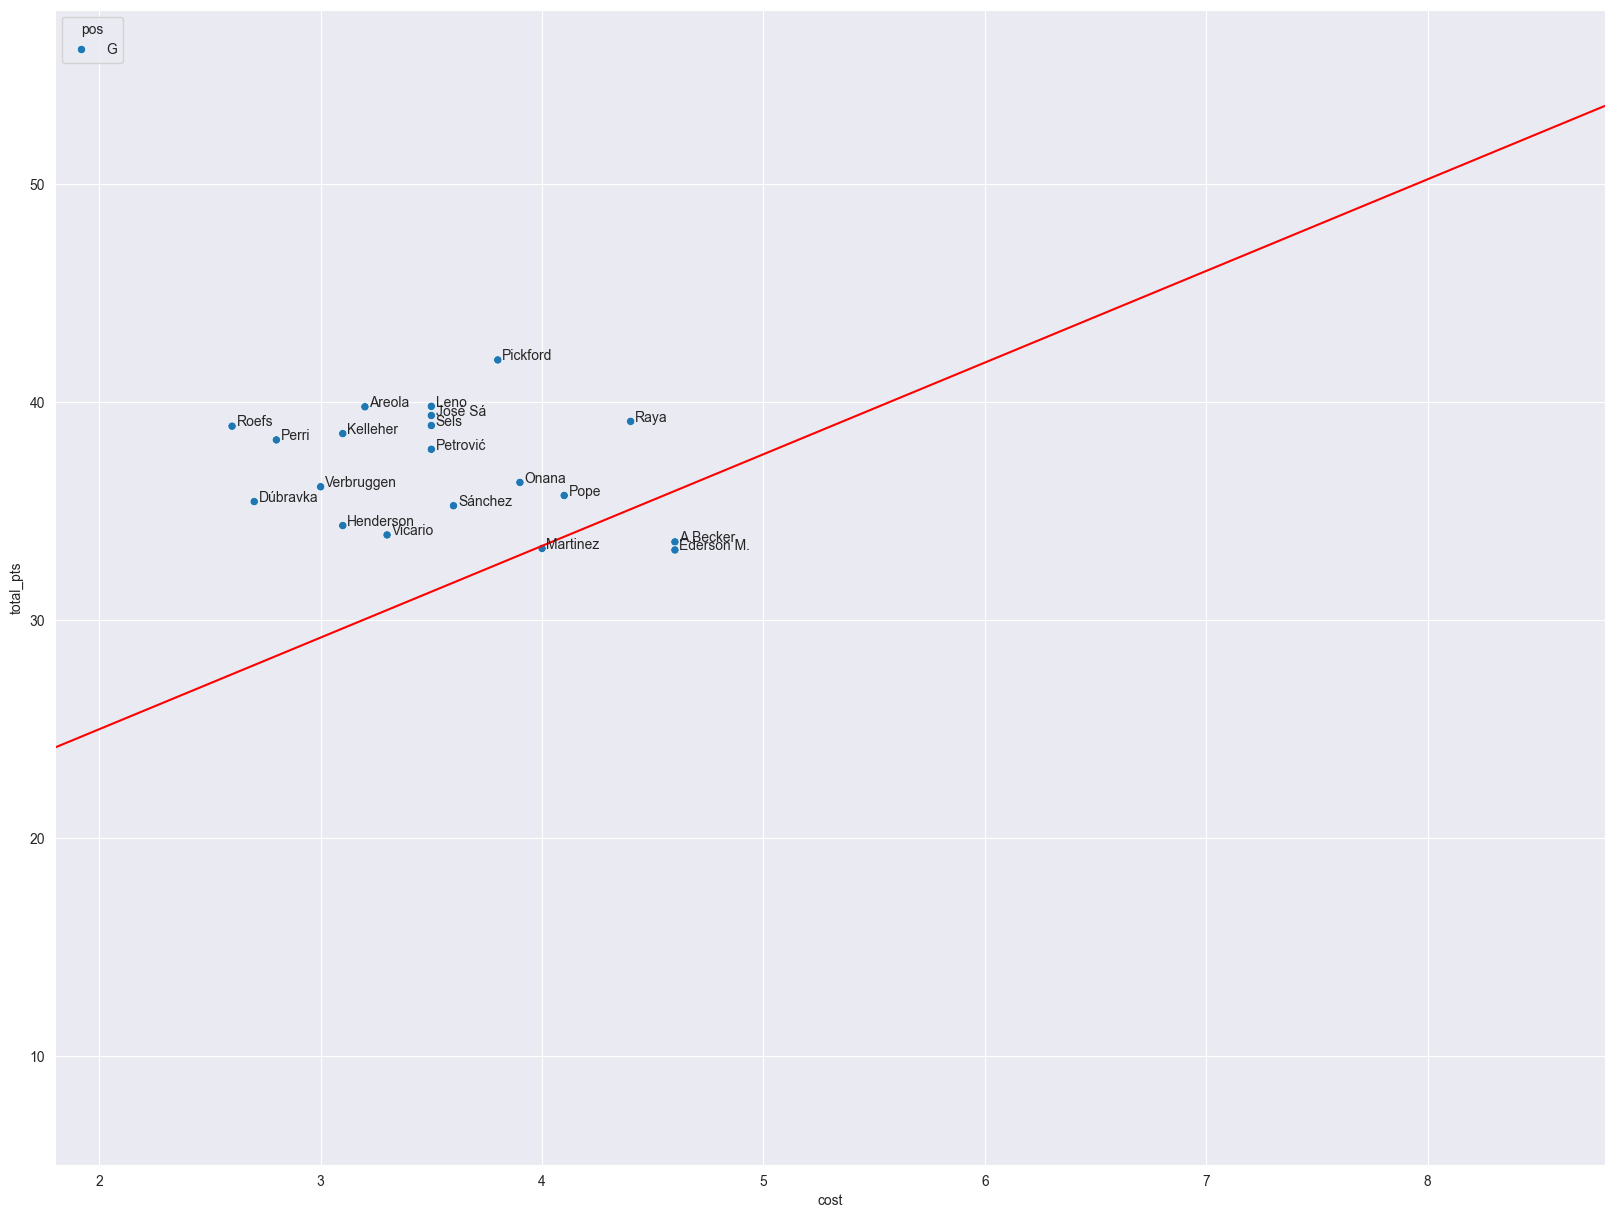

In [8]:
red_line_viz(format='tff', pos_group='g')

In [24]:
make_cap_matrix(format='cff', max_ev_diff=1)

,Below Best Cap,2025-08-15,2025-08-16,2025-08-17,2025-08-18,2025-08-22,2025-08-23,2025-08-24,2025-08-25,2025-08-29,2025-08-30,2025-08-31,2025-09-13,2025-09-14,2025-09-20,2025-09-21,2025-09-27,2025-09-28,2025-09-29,2025-10-04,2025-10-18,2025-10-25,2025-11-01
0,0.0,M.Salah,Haaland,Palmer,Bogle Rodon,Palmer,Haaland,B.Fernandes Eze,M.Salah,Watkins,B.Fernandes,Haaland,Eze,M.Salah,M.Salah,Watkins,Haaland,Solanke,Pickford,B.Fernandes,M.Salah,Palmer,Haaland
1,-0.1,,,,Pickford,,,Van Hecke,,,,,,,,,,,,,Haaland,,M.Salah
2,-0.2,,,,Perri,,,,,,,,,,,,,Saka,Bowen Tarkowski,,,,
3,-0.3,,,,,,,Muñoz,,,,,,,,,,Strand Larsen,Areola Ndiaye,,,,Palmer
4,-0.4,,,,Tarkowski,,,,,Eze,,,,Haaland,,,,Isak,Todibo,,,,
5,-0.5,,,,Mykolenko,,,,,,,,Palmer,,,,,Romero,Mykolenko O'Brien Kilman,,,,
6,-0.6,,,,O'Brien Branthwaite,,,Mateta,,,,,Muñoz,,,,,Saliba,L.Paquetá Wan-Bissaka Branthwaite,,,,
7,-0.7,,,,Ndiaye Gana,,,,,,,,Isak,,Virgil,,,Gabriel,,,,,
8,-0.8,,,,Piroe Gudmundsson,,,Sarr,,Muñoz,,,Mateta,,,,,Pedro Porro,,,,,
9,-0.9,,,,,,,,Isak,Mateta,Palmer,M.Salah,,,Palmer,Tielemans,,Gomes Kudus,Gana McNeil Alcaraz,,Palmer,,


# Optimisation

In [9]:
def preprocess_dfs(ev_df, fixture_df, format='tff', initial_team=None, last_date=None,
                   total_pts_cutoff=None, ppm_cutoff=None, weekly_decay=None):

    fixture_map = fixture_df.copy()
    if format in ['fpl', 'fanteam', 'cff']:
        fixture_map = fixture_map.loc[fixture_map['in_fpl']]
    elif format == 'tff':
        fixture_map = fixture_map.loc[fixture_map['in_tff']]
    fixture_map = fixture_map.loc[:, ['datetime_str', 'date_str', 'datetime_obj', 'fpl_gw', 'tff_gw']]

    dupes_to_drop = {'fpl':'fpl_gw', 'tff':'datetime_str', 'sdt':'fpl_gw', 'cff':'date_str', 'fanteam':'fpl_gw'}[format]
    fixture_map = fixture_map.drop_duplicates(subset=dupes_to_drop, keep="first").reset_index(drop=True)

    # add matchtime labels
    fixture_map['matchtime'] = 1
    matchtime_counter = 1
    for index, row in fixture_map.copy().iterrows():
        fixture_map.loc[index, 'matchtime'] = matchtime_counter
        matchtime_counter += 1
    
    if format == 'tff':
        ev_df = ev_df.rename(columns={row['datetime_str']: f"{row['matchtime']}_pts" for index, row in fixture_map.iterrows()})
    elif format == 'cff':
        ev_df = ev_df.rename(columns={row['date_str']: f"{row['matchtime']}_pts" for index, row in fixture_map.iterrows()})
    else:
        ev_df = ev_df.rename(columns={str(row['matchtime']): f"{row['matchtime']}_pts" for index, row in fixture_map.iterrows()})

    # remove matches after last date
    if last_date is not None:
        dropped_matchtimes = []
        if isinstance(last_date, int):
            for index, row in fixture_map.copy().iterrows():
                if row['fpl_gw'] > last_date:
                    dropped_matchtimes += [f"{row['matchtime']}_pts"]
                    fixture_map = fixture_map.loc[fixture_map['datetime_str']!=row['datetime_str']]
        else:
            last_date_str = datetime.datetime.strftime(parser.parse(last_date) + datetime.timedelta(days=1), "%Y-%m-%d")
            for index, row in fixture_map.copy().iterrows():
                if row['datetime_str'] > last_date_str:
                    dropped_matchtimes += [f"{row['matchtime']}_pts"]
                    fixture_map = fixture_map.loc[fixture_map['datetime_str']!=row['datetime_str']]
        dropped_matchtimes = [x for x in dropped_matchtimes if x in ev_df.columns]
        ev_df = ev_df.drop(dropped_matchtimes, axis=1)

    matchtimes_to_keep = []
    for column in ev_df.columns:
        if '_pts' in column and 'total' not in column:
            m = column.split('_')[0]
            matchtimes_to_keep += [int(m)]
    fixture_map = fixture_map.loc[fixture_map['matchtime'].isin(matchtimes_to_keep)]
    
    # add decay column
    if weekly_decay is not None:
        first_date_str = list(fixture_map['date_str'])[0]
        daily_decay = weekly_decay ** (1/7)
        fixture_map['decay'] = 1.0
        for index, row in fixture_map.copy().iterrows():
            fixture_map.loc[index, 'decay'] = daily_decay**(parser.parse(row['date_str'])-parser.parse(first_date_str)).days

    # remove players outside of pts and ppm cutoffs
    if initial_team is None:
        initial_team = []
    if total_pts_cutoff is not None:
        total_pts_cutoff = total_pts_cutoff * ev_df['total_pts'].max()
        ev_df = ev_df.loc[(ev_df['total_pts']>total_pts_cutoff) | (ev_df['fpl_code'].isin(initial_team))]
    if ppm_cutoff is not None:
        ppm_cutoff = ppm_cutoff * ev_df['ppm'].max()
        ev_df = ev_df.loc[(ev_df['ppm']>ppm_cutoff) | (ev_df['fpl_code'].isin(initial_team))]

    fixture_map = fixture_map.set_index('matchtime')
    ev_df = ev_df.set_index('fpl_code')
    
    return {'ev_df': ev_df, 'fixture_map': fixture_map}

In [10]:
def show_team_from_list(team_list=[], format='tff'):

    if len(team_list)>0:

        player_data = pd.read_csv(f'../output/{format}_ev.csv')
        team_data = player_data.loc[player_data['fpl_code'].isin(team_list)]
        team_data = team_data.sort_values(by='pos')
        total_cost = round(team_data['cost'].sum(),1)

        team_info = 'Initial team:'
        for pos in ['G', 'D', 'M', 'F']:
            pos_list = [row['player'] for index, row in team_data.loc[team_data['pos']==pos].iterrows()]
            if len(pos_list) > 0:
                team_info += '\n'+', '.join(pos_list)

        team_info += f'\nTeam cost: £{total_cost}m'

    else:
        team_info = 'No initial team'

    print(team_info)
    return team_info

def read_team_json(format='tff', options={}):

    team_list = []

    with open(f'../teams/{format}_team.json', 'r') as fp:
        team_dict = json.load(fp)

    with open(f'../solve_settings/{format}_settings.json', 'r') as fp:
        options = json.load(fp)

    if options.get('use_team_json', False):

        if format == 'tff':
            team_number = options.get("team_number", 1)
            lineup_dict = team_dict['result']['teams'][team_number-1]['lineup']
            for key, value in lineup_dict.items():
                for p_id in value:
                    team_list += [p_id]

        if format == 'sdt':
            lineup_dict = team_dict['success']['team']['lineup']
            for key, value in lineup_dict.items():
                for p_id in value:
                    team_list += [p_id]

        if format == 'cff':
            lineup_dict = team_dict['team_data']['current_team']
            for key, p_list in lineup_dict.items():
                for player in p_list:
                    team_list += [player['PlayerID']]

    else:
        team_list = options.get('initial_team', [])

    team_info_str = show_team_from_list(team_list=team_list, format=format)

    return team_list, team_info_str

def get_random_id(n):
    return ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(n))

In [ ]:
def solve(format='tff', sim_number=1):

    with open(f'../solve_settings/{format}_settings.json', 'r') as fp:
        options = json.load(fp)

    last_date = options.get("last_date", 38)
    weekly_decay = options.get('weekly_decay', 0.95)
    vicecap_weight = options.get("vicecap_weight", 0.05)
    transfer_cost = options.get("transfer_cost", 6)
    total_pts_cutoff = options.get('total_pts_cutoff', 0.3)
    ppm_cutoff = options.get('ppm_cutoff', 0.5)
    gw_transfers_remaining = options.get("gw_transfers_remaining",5)
    exclusions = options.get("exclusions", None)
    keeps = options.get("keeps", None)
    total_transfers_remaining = options.get("total_transfers_remaining", 40)
    preseason = options.get("preseason", False)

    show_solve_results = options.get("show_solve_results", True)
    show_non_team_ev = options.get("show_non_team_ev", False)

    solver_type = options.get("solver_type", "highs")
    time_limit = options.get("soltime_limitver_type", 300)
    presolve = options.get("presolve", "on")
    use_cmd = options.get("use_cmd", True)
    delete_tmp = options.get("delete_tmp", True)
    
    ev_df = pd.read_csv(f'../output/{format}_ev.csv')
    fixture_df = pd.read_csv('../fixtures/fixture_df.csv')

    initial_team, team_info_str = read_team_json(format=format)

    print('\nPlayers before cutoff:\t', len(ev_df))

    dfs = preprocess_dfs(ev_df, fixture_df, format=format, initial_team=initial_team, last_date=last_date,
                       total_pts_cutoff = total_pts_cutoff, 
                       ppm_cutoff = ppm_cutoff, 
                       weekly_decay = weekly_decay)
    f_map = dfs['fixture_map']
    ev_df = dfs['ev_df']
    
    print('Players after cutoff:\t', len(ev_df))
    
    horizon = len(f_map)
    problem_id = get_random_id(5)
    problem_name = f'{format}_mp_h{horizon}_d{weekly_decay}_{problem_id}'

    # Sets
    players = ev_df.index.tolist()
    # element_types = type_data.index.tolist()
    matchtimes = list(f_map.index)
    all_matchtimes = [matchtimes[0]-1] + matchtimes    

    if format == 'tff':
        tff_gameweeks = list(f_map['tff_gw'].unique())
        gw_transfer_allowance = {w: 5 for w in tff_gameweeks}
        gw_transfer_allowance[tff_gameweeks[0]] = gw_transfers_remaining

        pos_limits ={"G":{"min":1, "max":1},
                     "D":{"min":3, "max":5},
                     "M":{"min":3, "max":5},
                     "F":{"min":1, "max":3}} 
        max_team_cost = 50
    elif format == 'cff':
        pos_limits ={"G":{"min":1, "max":1},
                     "D":{"min":3, "max":5},
                     "M":{"min":3, "max":5},
                     "F":{"min":1, "max":3}} 
        max_team_cost = 100
    elif format == 'sdt':
        pos_limits ={"G":{"min":1, "max":1},
                     "D":{"min":3, "max":5},
                     "M":{"min":3, "max":5},
                     "F":{"min":1, "max":3}} 
        if preseason:
            max_team_cost = 50

    # Model
    model = so.Model(name = problem_name)

    # Variables
    team = model.add_variables(players, all_matchtimes, name='team', vartype=so.binary)
    transfer_in = model.add_variables(players, matchtimes, name='transfer_in', vartype=so.binary)
    transfer_out = model.add_variables(players, matchtimes, name='transfer_out', vartype=so.binary)
    if format != 'tff':
        captain = model.add_variables(players, matchtimes, name='captain', vartype=so.binary)
        vicecap = model.add_variables(players, matchtimes, name='vicecap', vartype=so.binary)

    # Dictionaries
    team_type_count = {(t,m): so.expr_sum(team[p,m] for p in players if ev_df.loc[p, 'pos'] == t) for t in pos_limits.keys() for m in matchtimes}
    player_value = (ev_df['cost']).to_dict()
    team_value = {m: so.expr_sum(player_value[p] * team[p,m] for p in players) for m in matchtimes}
    points_player_day = {(p,m): ev_df.loc[p, f'{m}_pts'] for p in players for m in matchtimes}
    team_count = {m: so.expr_sum(team[p, m] for p in players) for m in matchtimes}
    total_number_of_transfers = so.expr_sum(transfer_out[p,m] for p in players for m in matchtimes) 
    mt_number_of_transfers = {m: so.expr_sum(transfer_out[p,m] for p in players) for m in matchtimes}
    if format == 'tff':
        gw_number_of_transfers = {w: so.expr_sum(mt_number_of_transfers[m] for m in matchtimes if int(f_map.loc[m, 'tff_gw']) == w) for w in tff_gameweeks}
    
    # Constraints: team
    if initial_team is not None:
        model.add_constraints((team[p, 0] == 1 for p in initial_team), name='initial_team_players')
        model.add_constraints((team[p, 0] == 0 for p in players if p not in initial_team), name='initial_team_others')
    else:
        initial_team = []
    if format in ['tff', 'cff', 'sdt']:
        model.add_constraints((team_count[m] == 11 for m in matchtimes), name='team_count')
    # Constraints: captaincy
    if format != 'tff':
        model.add_constraints((so.expr_sum(captain[p,m] for p in players) == 1 for m in matchtimes), name='captain_count')
        model.add_constraints((captain[p,m] <= team[p,m] for p in players for m in matchtimes), name='captain_squad_rel')
        if vicecap_weight > 0 and vicecap_weight < 1:
            model.add_constraints((so.expr_sum(vicecap[p,m] for p in players) == 1 for m in matchtimes), name='vicecap_count')
            model.add_constraints((vicecap[p,m] <= team[p,m] for p in players for m in matchtimes), name='vicecap_squad_rel')
            model.add_constraints((captain[p,m] + vicecap[p,m] <=1 for p in players for m in matchtimes), name='cap_vicecap_rel')
        else:
            model.add_constraints((so.expr_sum(vicecap[p,m] for p in players) == 0 for m in matchtimes), name='no_vicecap')
            vicecap_weight = 0
    # Constraints: formation and budget
    model.add_constraints((team_type_count[t,m] == [pos_limits[t]['min'], pos_limits[t]['max']] for t in pos_limits.keys() for m in matchtimes), name='valid_formation_1')
    if format == 'cff':
        model.add_constraints((team_type_count['D',m]-team_type_count['F',m] <= 3.5 for m in matchtimes), name='no_541')
    model.add_constraints((team_value[m] <= max_team_cost for m in matchtimes), name='team_budget')
    # Constraints: transfers
    model.add_constraints((team[p,m] == team[p,m-1] + transfer_in[p,m] - transfer_out[p,m] for p in players for m in matchtimes), name='team_transfer_rel')
    if format in ['cff', 'tff']:
        model.add_constraint(total_number_of_transfers <= total_transfers_remaining, name = 'transfer_allowance')
    if format == 'tff':
        model.add_constraints((gw_number_of_transfers[w] <= gw_transfer_allowance[w] for w in tff_gameweeks), name = 'gw_transfer_allowance')
    if format == 'sdt':
        model.add_constraints((mt_number_of_transfers[m] <= 2 for m in matchtimes), name = 'mt_transfer_allowance')
    # Constraints: forced players and transfers
    if exclusions is not None:
        model.add_constraints((team[e, m] == 0 for e in exclusions for m in matchtimes), name = 'force_exclude_players')
    if keeps is not None:
        model.add_constraints((team[e, m] == 1 for e in keeps for m in matchtimes), name = 'force_keep_players')

    # Objective
    if format == 'tff':
        md_xp = {m: so.expr_sum(points_player_day[p,m] * (team[p,m]) for p in players) for m in matchtimes}
    else:
        md_xp = {m: so.expr_sum(points_player_day[p,m] * (team[p,m] + captain[p,m] + vicecap_weight*vicecap[p,m]) for p in players) for m in matchtimes}

    eval_score = so.expr_sum(md_xp[m] * f_map.loc[m, 'decay'] + 0.000001*mt_number_of_transfers[m]*m for m in matchtimes) - total_number_of_transfers * transfer_cost
    model.set_objective(-eval_score, sense='N', name='total_decay_xp')

    # Solve Step
    model.export_mps(filename=f'tmp/{problem_name}_{problem_id}_{sim_number}.mps')
    
    if solver_type == 'cbc':
        command = f'cbc tmp/{problem_name}_{problem_id}_{sim_number}.mps sec {time_limit} solve solu tmp/{problem_name}_{problem_id}_{sim_number}_sol.txt'
        # !{command}
        os.system(command)
        # Read the solution back to the file
        with open(f'tmp/{problem_name}_{problem_id}_{sim_number}_sol.txt', 'r') as f:
            for v in model.get_variables():
                v.set_value(0)
            for line in f:
                if 'objective value' in line:
                    continue
                words = line.split()
                var = model.get_variable(words[1])
                var.set_value(float(words[2]))
    else:
        highs_exec = options.get('solver_path') or 'highs'
        command = f'{highs_exec} --presolve {presolve} --model_file tmp/{problem_name}_{problem_id}_{sim_number}.mps --time_limit {time_limit} --solution_file tmp/{problem_name}_{problem_id}_{sim_number}_sol.txt'
        # use_cmd is set to True to prevent highs from halting mid-process. It can be set to False if this does not happen on your machine
        if use_cmd:
            def print_output(process):
                while True:
                    output = process.stdout.readline()
                    if 'Solving report' in output:
                        time.sleep(0.5)
                        process.kill()
                    elif output == '' and process.poll() is not None:
                        break
                    elif output:
                        print(output.strip())

            process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
            output_thread = threading.Thread(target=print_output, args=(process,))
            output_thread.start()
            output_thread.join()
        else:
            os.system(command)

        with open(f'tmp/{problem_name}_{problem_id}_{sim_number}_sol.txt', 'r') as f:
            for v in model.get_variables():
                v.set_value(0)
            cols_started = False
            for line in f:
                if not cols_started and "# Columns" not in line:
                    continue
                elif "# Columns" in line:
                    cols_started = True
                    continue
                elif cols_started and line[0] != "#":
                    words = line.split()
                    v = model.get_variable(words[0])
                    try:
                        if v.get_type() == so.INT:
                            v.set_value(round(float(words[1])))
                        elif v.get_type() == so.BIN:
                            v.set_value(round(float(words[1])))
                        elif v.get_type() == so.CONT:
                            v.set_value(round(float(words[1]),3))
                    except:
                        print("Error", words[0], line)
                elif line[0] == "#":
                    break
    total_xp = round(so.expr_sum(points_player_day[p,m] * (team[p,m]) for p in players for m in matchtimes).get_value(), 2)
    eval_score = round(eval_score.get_value(), 2)

    # Generate a dataframe to display the solution
    plan = []
    for t in pos_limits.keys():
        for p in players:
            if so.expr_sum(team[p,m] + transfer_out[p,m] for m in matchtimes).get_value() >= 0.5 and ev_df.loc[p, 'pos'] == t:
                lp = ev_df.loc[p]
                if p in initial_team:
                    appendment = '*'
                else:
                    appendment = ''
                player_info = [p, lp['team'], lp['pos'], lp['cost'], lp['player']+appendment]
                for m in matchtimes:
                    current_points = round(points_player_day[p,m], 2)
                    if team[p,m].get_value() > 0.5:
                        score = f'{current_points}'
                        if format != 'tff':
                            if captain[p,m].get_value() > 0.5 and current_points>0.1:
                                score += 'c'
                            if vicecap[p,m].get_value() > 0.5 and current_points>0.1:
                                score += 'v'
                    elif show_non_team_ev and current_points > 0.2:
                        score = f'({current_points})'
                    else:
                        score = ''
                    player_info.append(score)
                plan.append(player_info)
    player_detail_columns = ['ID','Team', 'Pos','Cost','Name']
    numeric_header = player_detail_columns
    for m in matchtimes:
        numeric_header.append(f"{m}")
    plan_df = pd.DataFrame(plan, columns=numeric_header)
    plan_df = plan_df.replace(['0.0'],'-')
    plan_df = plan_df.replace(['0.0c'],'-')
    itb_row = ['','','','','ITB']
    for m in matchtimes:
        itb = max_team_cost - team_value[m].get_value()
        itb_row.append(itb)
    plan_df.loc[len(plan_df)] = itb_row
    daynum_header = 5*[''] + [ordinal(parser.parse(row['datetime_str']).strftime("%d")) for index, row in f_map.iterrows()]
    weekday_header = 5*[''] + [parser.parse(row['datetime_str']).strftime("%a") for index, row in f_map.iterrows()]
    tff_gw_header = 5*[''] + ['GW' + str(row['tff_gw']) for index, row in f_map.iterrows()]
    fpl_gw_header = 5*[''] + ['GW' + str(row['fpl_gw']) for index, row in f_map.iterrows()]
    month_header = 5*[''] + [parser.parse(row['datetime_str']).strftime("%b") for index, row in f_map.iterrows()]
    time_header = 5*[''] + [parser.parse(row['datetime_str']).strftime("%H:%M") for index, row in f_map.iterrows()]
    if format == 'tff':
        plan_df.columns = [month_header, tff_gw_header, weekday_header, daynum_header, time_header, numeric_header]
    elif format == 'cff':
        plan_df.columns = [month_header, fpl_gw_header, weekday_header, daynum_header, numeric_header]
    else:
        plan_df = plan_df.rename(columns={str(index): 'GW' + str(row['fpl_gw']) for index, row in f_map.iterrows()})

    transfers_made = int(total_number_of_transfers.get_value())
    
    clear_output(wait=True)

    if delete_tmp:
        folder = './tmp'
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print('Failed to delete %s. Reason: %s' % (file_path, e))

    if show_solve_results:
        print(team_info_str)
        display(plan_df)
        gw_horizon = 1 + f_map['fpl_gw'].max() - f_map['fpl_gw'].min()
        print(f'EV: {total_xp}\tEval: {eval_score}\tTransfers: {transfers_made}')
        print(f'Horizon: {gw_horizon}\tDecay: {weekly_decay}\tTransfer cost: {transfer_cost}')
    
    return{'model': model, 'total_xp': total_xp, 'eval_score': eval_score, 'plan': plan_df, 'transfers_made': transfers_made, 'fixture_map': f_map}

# Optimisation Results

Solver equipped for formats: 'tff', 'sdt', 'cff'

Edits to solver parameters can be made in the files in the 'solve_settings' folder

Your teams can be pasted into the 'teams' folder as json files for easy input, which can be found at the below addresses whilst logged in. The fanteam json must have fpl codes inputted manually, along with an up-to-date download of the csv file from the player data page in the 'input_data' folder

https://fantasy.premierleague.com/api/my-team/[YOUR_ID_HERE] (NB: needs the following script enabled in tampermonkey or violentmonkey: https://greasyfork.org/en/scripts/544446-get-current-fpl-team)

https://fantasyfootball.telegraph.co.uk/api/fantasy_team/epl/show_my

https://www.dreamteamfc.com/api/en_US/season/teams

https://www.cloud-ff.co.uk/team , copying the json response from POST https://europe-west2-cloudfantasy-449312.cloudfunctions.net/getUserTeam

In [14]:
r = solve(format='sdt')

No initial team


,ID,Team,Pos,Cost,Name,GW1,GW2,GW3,GW4,GW5,GW6,GW7,GW8,GW9,GW10
0,67089,NEW,G,2.0,Dúbravka,,,,5.8,5.45,5.88,3.57,5.43,3.56,5.46
1,201595,LEE,G,2.0,Perri,4.0,5.65,3.49,,,,,,,
2,215136,NFO,D,3.5,N.Williams,,,,,9.16,10.65,7.94,7.91,4.48,8.43
3,199796,AVL,D,3.5,Cash,,,,,,,8.02,7.14,3.37,6.56
4,437499,CRY,D,3.5,Lacroix,,,,,,7.37,7.1,6.86,3.36,6.62
5,17761,EVE,D,3.5,Tarkowski,4.94,9.23,4.56,8.07,,,,,,
6,226182,LEE,D,2.5,Bogle,5.08,6.15,4.03,5.89,4.27,4.04,,,,
7,487676,SUN,D,2.5,Hume,4.8,7.81,4.02,5.91,3.97,,,,,
8,244851,CHE,M,6.0,Palmer,8.32v,7.92,7.51v,14.51,13.47v,14.64,6.52,13.98v,10.14c,14.6v
9,223340,ARS,M,6.5,Saka,,,,13.05,11.35,,,11.92,6.63,12.97


EV: 904.75	Eval: 764.01	Transfers: 11
Horizon: 10	Decay: 0.95	Transfer cost: 2
